### Künstliche Intelligenz in kleinen und mittleren Betrieben ###
# Analyse der Mohn Filiale Sulgen #

In [23]:
# Importieren wichtiger Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc_analysis import abc_analysis # ABC-Analyse Version 1
%pip install inventorize3 # für ABC-Analyse Version 2
import inventorize3 as inv # für ABC-Analyse Version 2

Note: you may need to restart the kernel to use updated packages.


### 1. Einlesen und der Daten und erstes Understanding ###

Zu Beginn importieren wir die Daten und machen uns ein Bild vom Datensatz, seinen Dimensionen und den Wertebereichen.


In [24]:
data  = pd.read_csv("data.csv")
data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN


In [25]:
test = data[(data['Menge'] > 0) & (data['Bestellungen'] > 0)]
test.head()


,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
189418,2017-11-01 05:34:48,Sulgen Filiale,Laugengi.mit SoBlu,2.0,3.0,70.0,1.1,0.0,5.0,5.175,0.0,92.791667
189419,2017-11-01 05:38:12,Sulgen Filiale,Il pollo forte gefüllt,2.0,15.0,22.0,1.1,0.0,5.0,5.175,0.0,92.791667
189420,2017-11-01 05:38:23,Sulgen Filiale,Buttergipfeli,2.0,2.6,50.0,1.1,0.0,5.0,5.175,0.0,92.791667
189421,2017-11-01 05:50:23,Sulgen Filiale,Buttergipfeli,2.0,2.6,50.0,1.1,0.0,5.0,5.175,0.0,92.791667
189422,2017-11-01 05:54:32,Sulgen Filiale,Buttergipfeli,2.0,2.6,50.0,1.1,0.0,5.0,5.175,0.0,92.791667


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Zeitstempel                  727754 non-null  object 
 1   Filiale                      727754 non-null  object 
 2   Artikel                      727754 non-null  object 
 3   Menge                        727754 non-null  float64
 4   Umsatz                       727754 non-null  float64
 5   Bestellungen                 727754 non-null  float64
 6   Temperatur                   718722 non-null  float64
 7   Niederschlag                 725226 non-null  float64
 8   Globalstrahlung              718722 non-null  float64
 9   Temperatur Schnitt Tag       719687 non-null  float64
 10  Niederschlag Summe Tag       727754 non-null  float64
 11  Globalstrahlung Schnitt Tag  719687 non-null  float64
dtypes: float64(9), object(3)
memory usage: 66.6+ MB


Jetzt verschaffen wir uns einen Überblick welche Produkte im Datensatz enthalten sind.

In [27]:
n_produkte = data["Artikel"].unique()

# Erstellen einer Produktliste mit der verkauften Anzahl
produkt_liste = data[["Artikel", "Menge"]].groupby("Artikel").sum().sort_values(by="Menge", ascending=False).reset_index()


print("Es sind folgende Produkte im Datensatz enthalten: ")
print(produkt_liste)

Es sind folgende Produkte im Datensatz enthalten: 
                   Artikel     Menge
0            Buttergipfeli  384812.0
1       Laugengi.mit SoBlu  187591.0
2               Maisgipfel  180437.6
3             Laugenbrötli   95970.0
4            Weggli normal   83320.0
5          St. Gallerbürli   79307.0
6           Crèmeschnitten   71149.0
7            BT Nussgipfel   64025.3
8              Quarkzöpfli   63098.0
9        Butterzopf mittel   62872.0
10           Schoggibrötli   43954.0
11  Il pollo forte gefüllt   42164.0
12     Hefe-Vanille-Weggli   40206.0
13           Erdbeertörtli   26901.0


<font color=red>
<b> Offene Fragen: </b>

Warum gibt es bei Nussgipfel und Maisgipfel Dezimalstellen?
</font>


### 2. Vorbereitung des Dataframes ###

Als nächstes bereiten wir den Datensatz auf. 

Dafür werden :
- Spalten transformiert
- Ungenutzte Spalten entfernt
- NA Werte gefüllt oder entfernt
- Outlier aus dem Datensatz entfernt


#### 2.1. Transformation ganzer Spalten im Dataframe ####

In [28]:
data_backup = data.copy()

# Transformation des Datensatzes
data["Zeitstempel"] = pd.to_datetime(data["Zeitstempel"])
data["Uhrzeit"] = pd.to_datetime(data["Zeitstempel"]).dt.time
data["Stunde"] = pd.to_datetime(data["Zeitstempel"]).dt.hour
data["Datum"] = pd.to_datetime(data["Zeitstempel"]).dt.date
data["Wochentag"] = pd.to_datetime(data["Zeitstempel"]).dt.day_name()

data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Zeitstempel                  727754 non-null  datetime64[ns]
 1   Filiale                      727754 non-null  object        
 2   Artikel                      727754 non-null  object        
 3   Menge                        727754 non-null  float64       
 4   Umsatz                       727754 non-null  float64       
 5   Bestellungen                 727754 non-null  float64       
 6   Temperatur                   718722 non-null  float64       
 7   Niederschlag                 725226 non-null  float64       
 8   Globalstrahlung              718722 non-null  float64       
 9   Temperatur Schnitt Tag       719687 non-null  float64       
 10  Niederschlag Summe Tag       727754 non-null  float64       
 11  Globalstrahlung Schnitt Ta

In [30]:
# Konvertieren der Spalten in die richtige Datentypen
data["Datum"] = pd.to_datetime(data["Datum"]).dt.date
wochentag_reihenfolge = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["Wochentag"] = pd.Categorical(data["Wochentag"], categories = wochentag_reihenfolge, ordered = True)

# Entfernen nicht mehr benötigter Spalten
data = data.drop(columns = ["Filiale", "Zeitstempel"], axis = "columns")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      727754 non-null  object  
 1   Menge                        727754 non-null  float64 
 2   Umsatz                       727754 non-null  float64 
 3   Bestellungen                 727754 non-null  float64 
 4   Temperatur                   718722 non-null  float64 
 5   Niederschlag                 725226 non-null  float64 
 6   Globalstrahlung              718722 non-null  float64 
 7   Temperatur Schnitt Tag       719687 non-null  float64 
 8   Niederschlag Summe Tag       727754 non-null  float64 
 9   Globalstrahlung Schnitt Tag  719687 non-null  float64 
 10  Uhrzeit                      727754 non-null  object  
 11  Stunde                       727754 non-null  int64   
 12  Datum                        727754 non-null

In [31]:
print("Der Datensatz geht von {} bis {}.".format(data["Datum"].min(), data["Datum"].max()))

Der Datensatz geht von 2016-01-03 bis 2022-02-11.


In [32]:
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


#### 2.2 Trimmen des Datensatzes ####

Im nächsten Schritt werden Outlier aus dem Datensatz gelöscht.

In [33]:
# Im nächsten Schritt prüfen wir Transaktionen außerhalb der Öffnungszeiten. Im Maximum hat die Bäckerrei von 5:30 bis 19:00 geöffnet.
# Zu erst werden Transaktionen vor Öffnung geprüft.
data_4_uhr = data[data["Stunde"] == 4]
data_4_uhr.head()

# Da sich in einem Histogramm über den Umsatz pro Uhrzeit pro Tag Ausreißer um 4 Uhr finden, werden alle Einträge vor 5 Uhr entfernt.
data = data[data["Stunde"] >= 5]

In [34]:
# 
data_20_uhr = data[data["Stunde"] == 20]
data_20_uhr.head()

,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
28671,Hefe-Vanille-Weggli,1.0,1.7553,0.0,11.5,0.0,0.0,11.441667,0.0,257.291667,20:01:02,20,2016-04-21,Thursday
28672,BT Nussgipfel,1.0,1.9947,0.0,11.5,0.0,0.0,11.441667,0.0,257.291667,20:01:02,20,2016-04-21,Thursday


Nun löschen wir alle Duplikate im Dataframe

In [35]:
data.drop_duplicates(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719185 entries, 0 to 727753
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      719185 non-null  object  
 1   Menge                        719185 non-null  float64 
 2   Umsatz                       719185 non-null  float64 
 3   Bestellungen                 719185 non-null  float64 
 4   Temperatur                   710279 non-null  float64 
 5   Niederschlag                 716688 non-null  float64 
 6   Globalstrahlung              710279 non-null  float64 
 7   Temperatur Schnitt Tag       711227 non-null  float64 
 8   Niederschlag Summe Tag       719185 non-null  float64 
 9   Globalstrahlung Schnitt Tag  711227 non-null  float64 
 10  Uhrzeit                      719185 non-null  object  
 11  Stunde                       719185 non-null  int64   
 12  Datum                        719185 non-null

Da der Datensatz sowohl 719185 Werte vor und nach dem Löschen hatte, kann man davon ausgehen, dass es keine Duplikate gab.

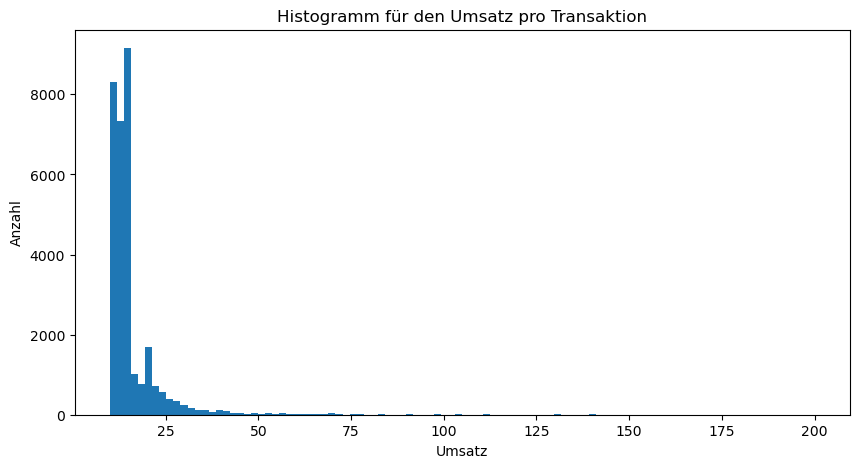

In [36]:
# Erstellen eines Histogramms für den Umsatz pro Transaktion
plt.figure(figsize= (10, 5))
plt.hist(data["Umsatz"], bins = 100, range= [10,200])
plt.title("Histogramm für den Umsatz pro Transaktion")
plt.xlabel("Umsatz")
plt.ylabel("Anzahl")
plt.show()

Bevor wir mit der Datenanalyse beginnen müssen wir noch Spalten droppen

In [37]:
corr = data.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap).format(precision=2)

,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Stunde
Menge,1.00,0.73,0.11,-0.02,-0.00,-0.03,0.00,0.00,0.00,-0.10
Umsatz,0.73,1.00,-0.04,0.02,-0.00,0.03,0.00,0.00,0.01,0.05
Bestellungen,0.11,-0.04,1.00,-0.07,0.00,-0.06,-0.04,0.01,-0.08,-0.11
Temperatur,-0.02,0.02,-0.07,1.00,-0.02,0.69,0.94,0.07,0.72,0.19
Niederschlag,-0.00,-0.00,0.00,-0.02,1.00,-0.16,-0.00,0.46,-0.14,0.02
Globalstrahlung,-0.03,0.03,-0.06,0.69,-0.16,1.00,0.58,-0.14,0.78,0.11
Temperatur Schnitt Tag,0.00,0.00,-0.04,0.94,-0.00,0.58,1.00,0.08,0.74,-0.03
Niederschlag Summe Tag,0.00,0.00,0.01,0.07,0.46,-0.14,0.08,1.00,-0.19,0.00
Globalstrahlung Schnitt Tag,0.00,0.01,-0.08,0.72,-0.14,0.78,0.74,-0.19,1.00,-0.03
Stunde,-0.10,0.05,-0.11,0.19,0.02,0.11,-0.03,0.00,-0.03,1.00


Als nächstes droppen wir Temeratur und Globalstrahlung, da deren Informationen ebenfalls durch den Tagesdurchschnitt erklärt werden können.

In [38]:
data = data.drop(columns = ["Temperatur", "Globalstrahlung"], axis = "columns")
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


### 2.3 Hinzufügen weiterer Datensätze ###

### 3. Erste Plots ###

/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

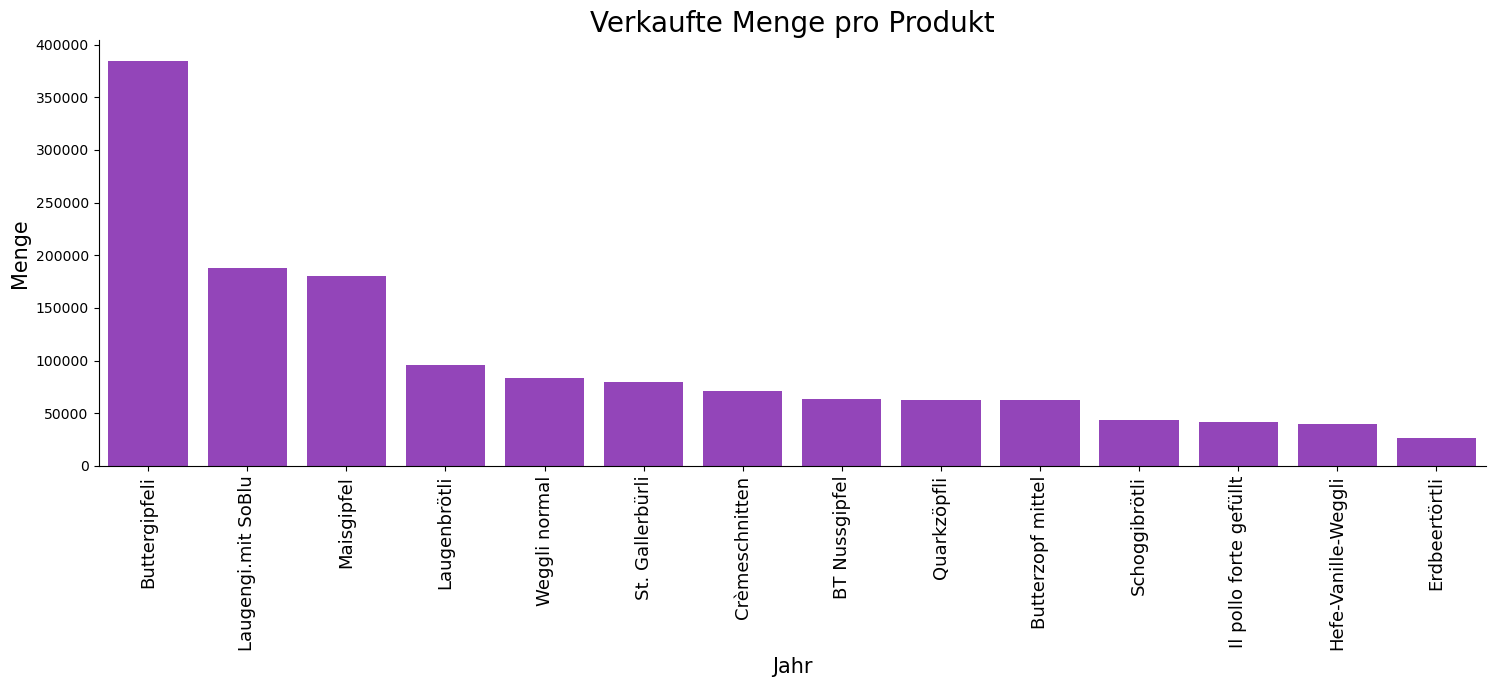

In [39]:
g = sns.catplot(kind = 'bar', x = 'Artikel', y = 'Menge', data = produkt_liste
                , color = 'darkorchid', size = 5, aspect = 3)
g.set_xticklabels(rotation=90)

# Set the title and labels
plt.title('Verkaufte Menge pro Produkt', size = 20)
plt.xticks(size=13)
plt.xlabel('Jahr', size=15)
plt.ylabel('Menge', size=15)
plt.show

Verkaufte Menge letzte 12 Monate

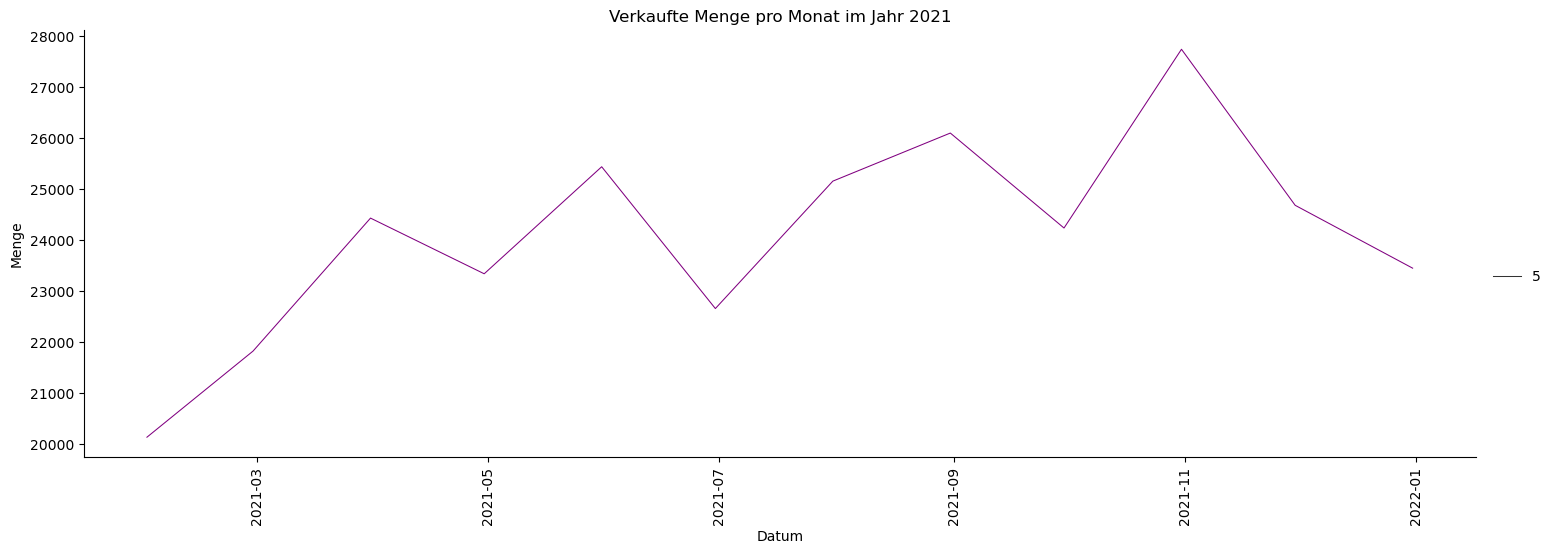

In [40]:
# Datum zu Datetiem 
data['Datum'] = pd.to_datetime(data['Datum'])

# Nur Daten aus dem Jahr 2021 auswählen
data_2021 = data[(data["Datum"] >= "2021-01-01") & (data['Datum'] <= "2021-12-31")]

# Datum als Index festlegen
data_2021.set_index('Datum', inplace=True)

# Resample and sum the 'Menge' column monthly
menge_2021 = data_2021.resample('M')['Menge'].sum().reset_index()

# Plotten der Daten
menge_2021_plt = sns.relplot(kind='line', x='Datum', y='Menge', data=menge_2021, color='purple', size = 5, aspect = 3, linewidth = 5)
plt.xticks(rotation=90)
plt.title('Verkaufte Menge pro Monat im Jahr 2021')
plt.show()


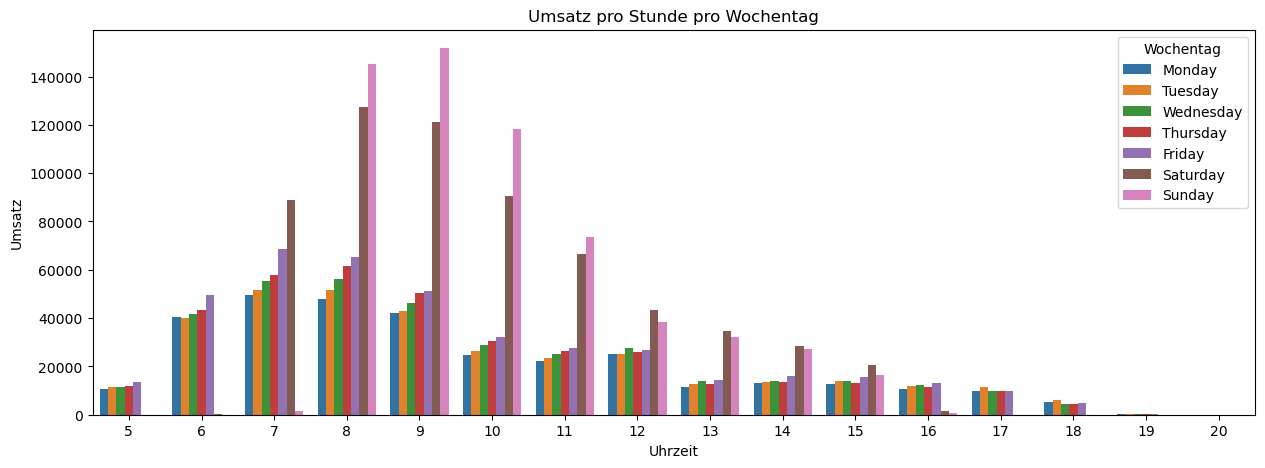

In [41]:
# Erstellen eines Plots mit Uhrzeit und Umsatz

# Gruppieren der Daten nach Uhrzeit und Wochentag und berechnung des Durchschnittlichen Umsatzes
avg_umsatz = data.groupby(["Stunde", "Wochentag"])["Umsatz"].sum().reset_index()

#Erstellen des Plots
plt.figure(figsize = (15,5))
ax = sns.barplot(data=avg_umsatz, x="Stunde", y="Umsatz", hue="Wochentag")

ax.set_xlabel("Uhrzeit")
ax.set_ylabel("Umsatz")
ax.set_title("Umsatz pro Stunde pro Wochentag")
ax.legend(title = "Wochentag", loc = "upper right")
plt.show()




Wichtige Punkte: 
- Sonntag 7 Uhr dip, weil öffnen erst um 8 
- Spikes am Wochenende
- Später im verlauf der Woche 
- Schließen Sonntags um 12 --> Verkaufen viel nach 12 --> Andere öffnungszeiten früher

## 5.1 ABC-Analyse (Version 1)

Für die ABC-Analyse haben wir aktuell nur 14 Produkte aus dem gesamten Katalog. Deshalb kann es sein, dass die Analyse ungewöhnlich aussieht. 

In [42]:
# Quelle: https://www.youtube.com/watch?v=g0W8e7na16k&t=287s
# Wir müssen den Datensatz zunächst umformen. Wir benötigen lediglich die unterschiedlichen Artikel (inkl. Menge & Umsatz pro Artikel)
dataABC = data.groupby(['Artikel']).agg(Menge=('Menge',np.sum),Umsatz=('Umsatz',np.sum)).reset_index()


In [43]:
# Datensatz
dataABC.head()

,Artikel,Menge,Umsatz
0,BT Nussgipfel,63750.3,170888.1839
1,Buttergipfeli,380642.5,510542.0167
2,Butterzopf mittel,62808.0,394777.3602
3,Crèmeschnitten,70883.0,240532.9746
4,Erdbeertörtli,26792.0,112765.2629


/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/abc_analysis/abc_analysis.py:163: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = pd.Series([0]).append(y)
/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/abc_analysis/abc_analysis.py:164: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.Series([0]).append(x)


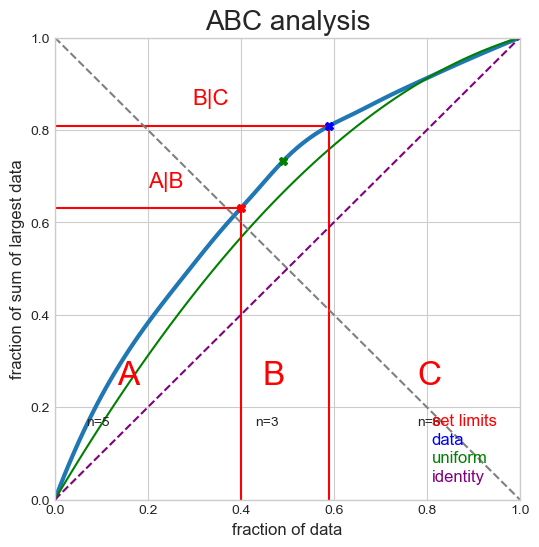

In [44]:
abc_umsatz = abc_analysis(dataABC['Umsatz'], True)


/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/abc_analysis/abc_analysis.py:163: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = pd.Series([0]).append(y)
/Users/moritzwissel/opt/anaconda3/lib/python3.9/site-packages/abc_analysis/abc_analysis.py:164: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.Series([0]).append(x)


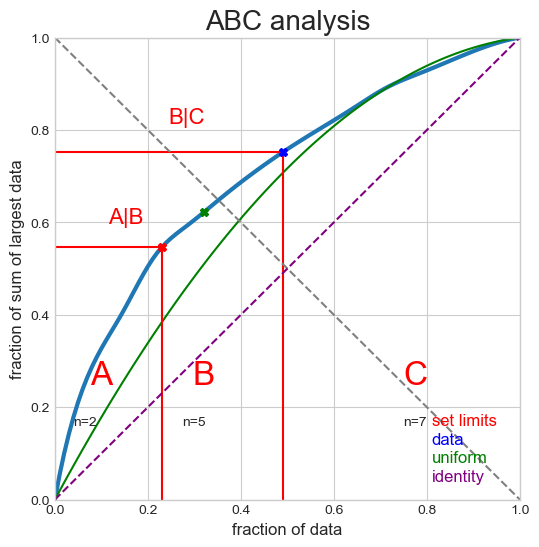

In [45]:
# abc_menge = abc_analysis(dataABC['Menge'], True)
abc_umsatz = abc_analysis(dataABC['Menge'], True, )

In [46]:
# Nun wollen wir jeden Artikel kategorisieren

a_index = abc_umsatz['Aind']
b_index = abc_umsatz['Bind']
c_index = abc_umsatz['Cind']

# Neue Spalte im Datensatz mit der Kategorisierung

cond_list = [dataABC.index.isin(a_index),
             dataABC.index.isin(b_index),
             dataABC.index.isin(c_index),
             ]

choice_list = ['A', 'B', 'C']

dataABC['Kategorie'] = np.select(cond_list, choice_list)
dataABC.sort_values(by=['Kategorie'])



,Artikel,Menge,Umsatz,Kategorie
1,Buttergipfeli,380642.5,510542.0167,A
8,Laugengi.mit SoBlu,186385.0,279846.3822,A
3,Crèmeschnitten,70883.0,240532.9746,B
7,Laugenbrötli,95742.5,95640.4229,B
9,Maisgipfel,179040.6,268815.9906,B
12,St. Gallerbürli,79097.0,110594.5840,B
13,Weggli normal,83048.0,91283.8801,B
0,BT Nussgipfel,63750.3,170888.1839,C
2,Butterzopf mittel,62808.0,394777.3602,C
4,Erdbeertörtli,26792.0,112765.2629,C


In [47]:
dataABC

,Artikel,Menge,Umsatz,Kategorie
0,BT Nussgipfel,63750.3,170888.1839,C
1,Buttergipfeli,380642.5,510542.0167,A
2,Butterzopf mittel,62808.0,394777.3602,C
3,Crèmeschnitten,70883.0,240532.9746,B
4,Erdbeertörtli,26792.0,112765.2629,C
5,Hefe-Vanille-Weggli,39990.0,99684.7256,C
6,Il pollo forte gefüllt,42087.0,315529.6546,C
7,Laugenbrötli,95742.5,95640.4229,B
8,Laugengi.mit SoBlu,186385.0,279846.3822,A
9,Maisgipfel,179040.6,268815.9906,B


## 5.2 ABC-Analyse (Version 2)

In [48]:
# Quelle: https://www.youtube.com/watch?v=V8Mz91gaXmQ&t=1075s
# Anmerkung: Resultat bzw. Klassifizierung ist nich gleich wie bei der Version 1. Deshalb habe ich beides mal drin gelassen.
#            Muss man noch angeschaut werden. 

# Wir müssen den Datensatz zunächst umformen. Wir benötigen lediglich die unterschiedlichen Artikel (inkl. Menge & Umsatz pro Artikel)
data_abc = data.groupby(['Artikel']).agg(Menge=('Menge',np.sum),Umsatz=('Umsatz',np.sum)).reset_index()

data_abc.head()

,Artikel,Menge,Umsatz
0,BT Nussgipfel,63750.3,170888.1839
1,Buttergipfeli,380642.5,510542.0167
2,Butterzopf mittel,62808.0,394777.3602
3,Crèmeschnitten,70883.0,240532.9746
4,Erdbeertörtli,26792.0,112765.2629


In [49]:
# Nun klassifizieren wir die Produkte (A, B und C)

data_abc_analyse = inv.ABC(data_abc[['Artikel','Umsatz']])

In [50]:
# Nun wurde der Datensatz mit der Spalte "Category" erweitert.  
data_abc_analyse

,Artikel,Umsatz,Percentage,comulative,Category
1,Buttergipfeli,510542.0167,0.168006,0.168006,A
2,Butterzopf mittel,394777.3602,0.129911,0.297917,A
6,Il pollo forte gefüllt,315529.6546,0.103833,0.401749,A
8,Laugengi.mit SoBlu,279846.3822,0.092090,0.493839,A
9,Maisgipfel,268815.9906,0.088460,0.582300,A
10,Quarkzöpfli,244785.0807,0.080552,0.662852,A
3,Crèmeschnitten,240532.9746,0.079153,0.742005,A
0,BT Nussgipfel,170888.1839,0.056235,0.798240,A
4,Erdbeertörtli,112765.2629,0.037108,0.835348,B
12,St. Gallerbürli,110594.5840,0.036394,0.871742,B


In [51]:
# Count of categories
data_abc_analyse.Category.value_counts()

# Resultat: 8 Artikel sind A-Produkte, 4 Artikel sind B-Produkte und 2 Artikel sind C-Produkte.

A    8
B    4
C    2
Name: Category, dtype: int64

In [52]:
# Nun wollen wir noch wissen wie viel Prozent der Verkauften Artikel die A,B und C-Produkte ausmachen. 

data_ABC_summary = data_abc_analyse.groupby('Category').agg(Count=('Artikel', np.count_nonzero),Prozentsatz=('Percentage',np.sum)).reset_index()
data_ABC_summary['Prozentsatz']=data_ABC_summary['Prozentsatz']*100
data_ABC_summary

# Resultat: Die A-Produkte machen 79.8% aus, die B-Produkte 14.02% und die C-Produkte 6.2%. 

,Category,Count,Prozentsatz
0,A,8,79.824000
1,B,4,14.024812
2,C,2,6.151188


<AxesSubplot:xlabel='Category', ylabel='count'>

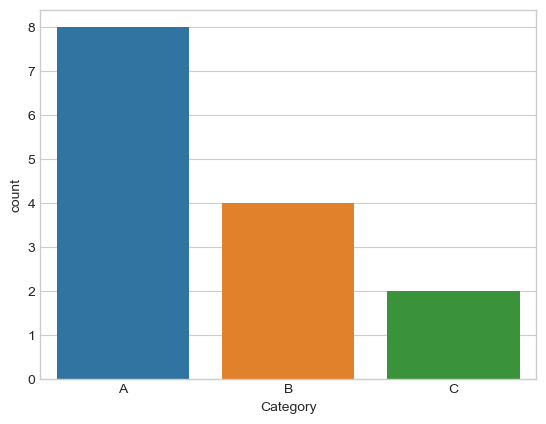

In [53]:
# Visualisierung der ABC Analyse

sns.countplot(x='Category', data=data_abc_analyse, label=True)

<AxesSubplot:xlabel='Category', ylabel='Umsatz'>

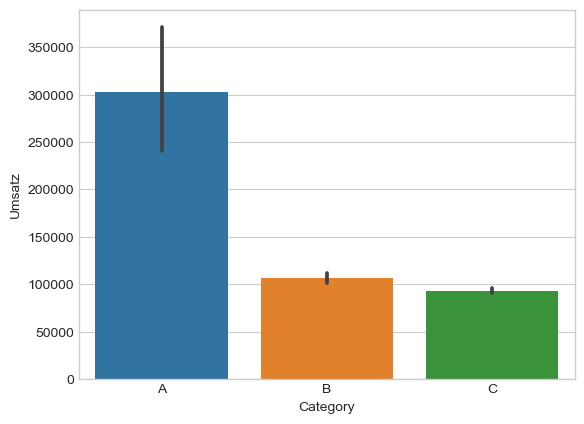

In [54]:
# Visualisierung ABC Analyse nach volume of sales

sns.barplot(x='Category', y='Umsatz', data=data_abc_analyse)

## 5.3 ABC-Analyse Version 3 

### ABC-Analyse (Umsatz)

In [55]:
# Datensatz erstellen
data_abc_manual = data.groupby(['Artikel']).agg(Menge=('Menge',np.sum),Umsatz=('Umsatz',np.sum)).reset_index()
data_abc_manual

,Artikel,Menge,Umsatz
0,BT Nussgipfel,63750.3,170888.1839
1,Buttergipfeli,380642.5,510542.0167
2,Butterzopf mittel,62808.0,394777.3602
3,Crèmeschnitten,70883.0,240532.9746
4,Erdbeertörtli,26792.0,112765.2629
5,Hefe-Vanille-Weggli,39990.0,99684.7256
6,Il pollo forte gefüllt,42087.0,315529.6546
7,Laugenbrötli,95742.5,95640.4229
8,Laugengi.mit SoBlu,186385.0,279846.3822
9,Maisgipfel,179040.6,268815.9906


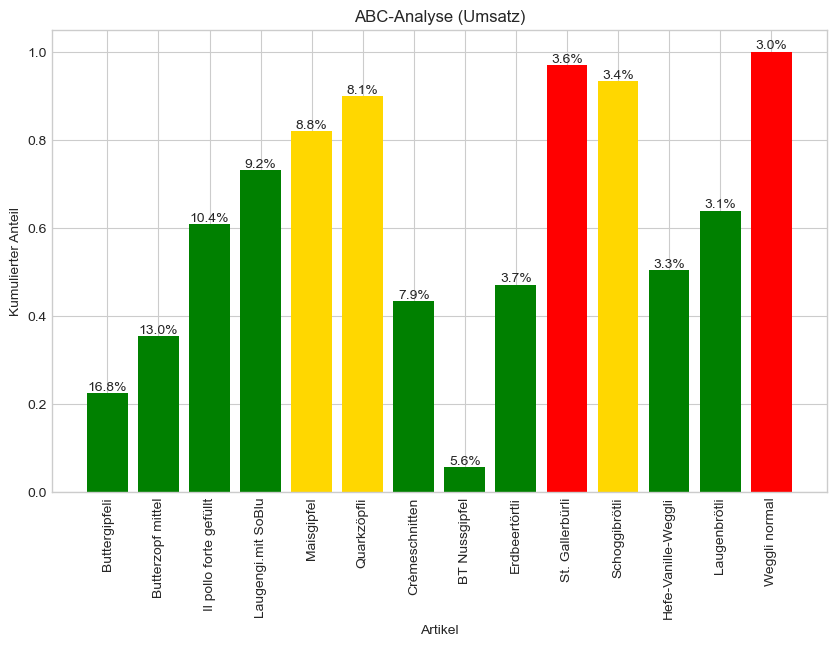

In [56]:
# Calculate the cumulative value and percentage
data_abc_manual['Cumulative_Value'] = data_abc_manual['Umsatz'].cumsum()
total_value = data_abc_manual['Umsatz'].sum()
data_abc_manual['Cumulative_Percentage'] = (data_abc_manual['Cumulative_Value'] / total_value)
data_abc_manual['Percentage'] = data_abc_manual['Umsatz'] / total_value

# Define the ABC classification function
def abc_classification(percentage):
    if percentage <= 0.80:
        return 'A'
    elif percentage <= 0.95:
        return 'B'
    else:
        return 'C'

# Apply the ABC classification to the data
data_abc_manual['Category'] = data_abc_manual['Cumulative_Percentage'].apply(abc_classification)

# Sort the DataFrame by Umsatz in descending order
data_abc_manual = data_abc_manual.sort_values(by='Umsatz', ascending=False)

# Plot ABC-Analysis
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(data_abc_manual['Artikel'], data_abc_manual['Cumulative_Percentage'], 
              color=['green' if c == 'A' else 'gold' if c == 'B' else 'red' for c in data_abc_manual['Category']])
ax.set_ylabel('Kumulierter Anteil')
ax.set_xlabel('Artikel')
ax.set_title('ABC-Analyse (Umsatz)')
plt.xticks(rotation=90)

# Add percentage labels to the bars
for bar, pct in zip(bars, data_abc_manual['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(pct), ha='center', va='bottom', )


plt.savefig('ABC-Analyse (Umsatz)', dpi=500, bbox_inches='tight')
plt.show()

### ABC-Analyse (Menge)


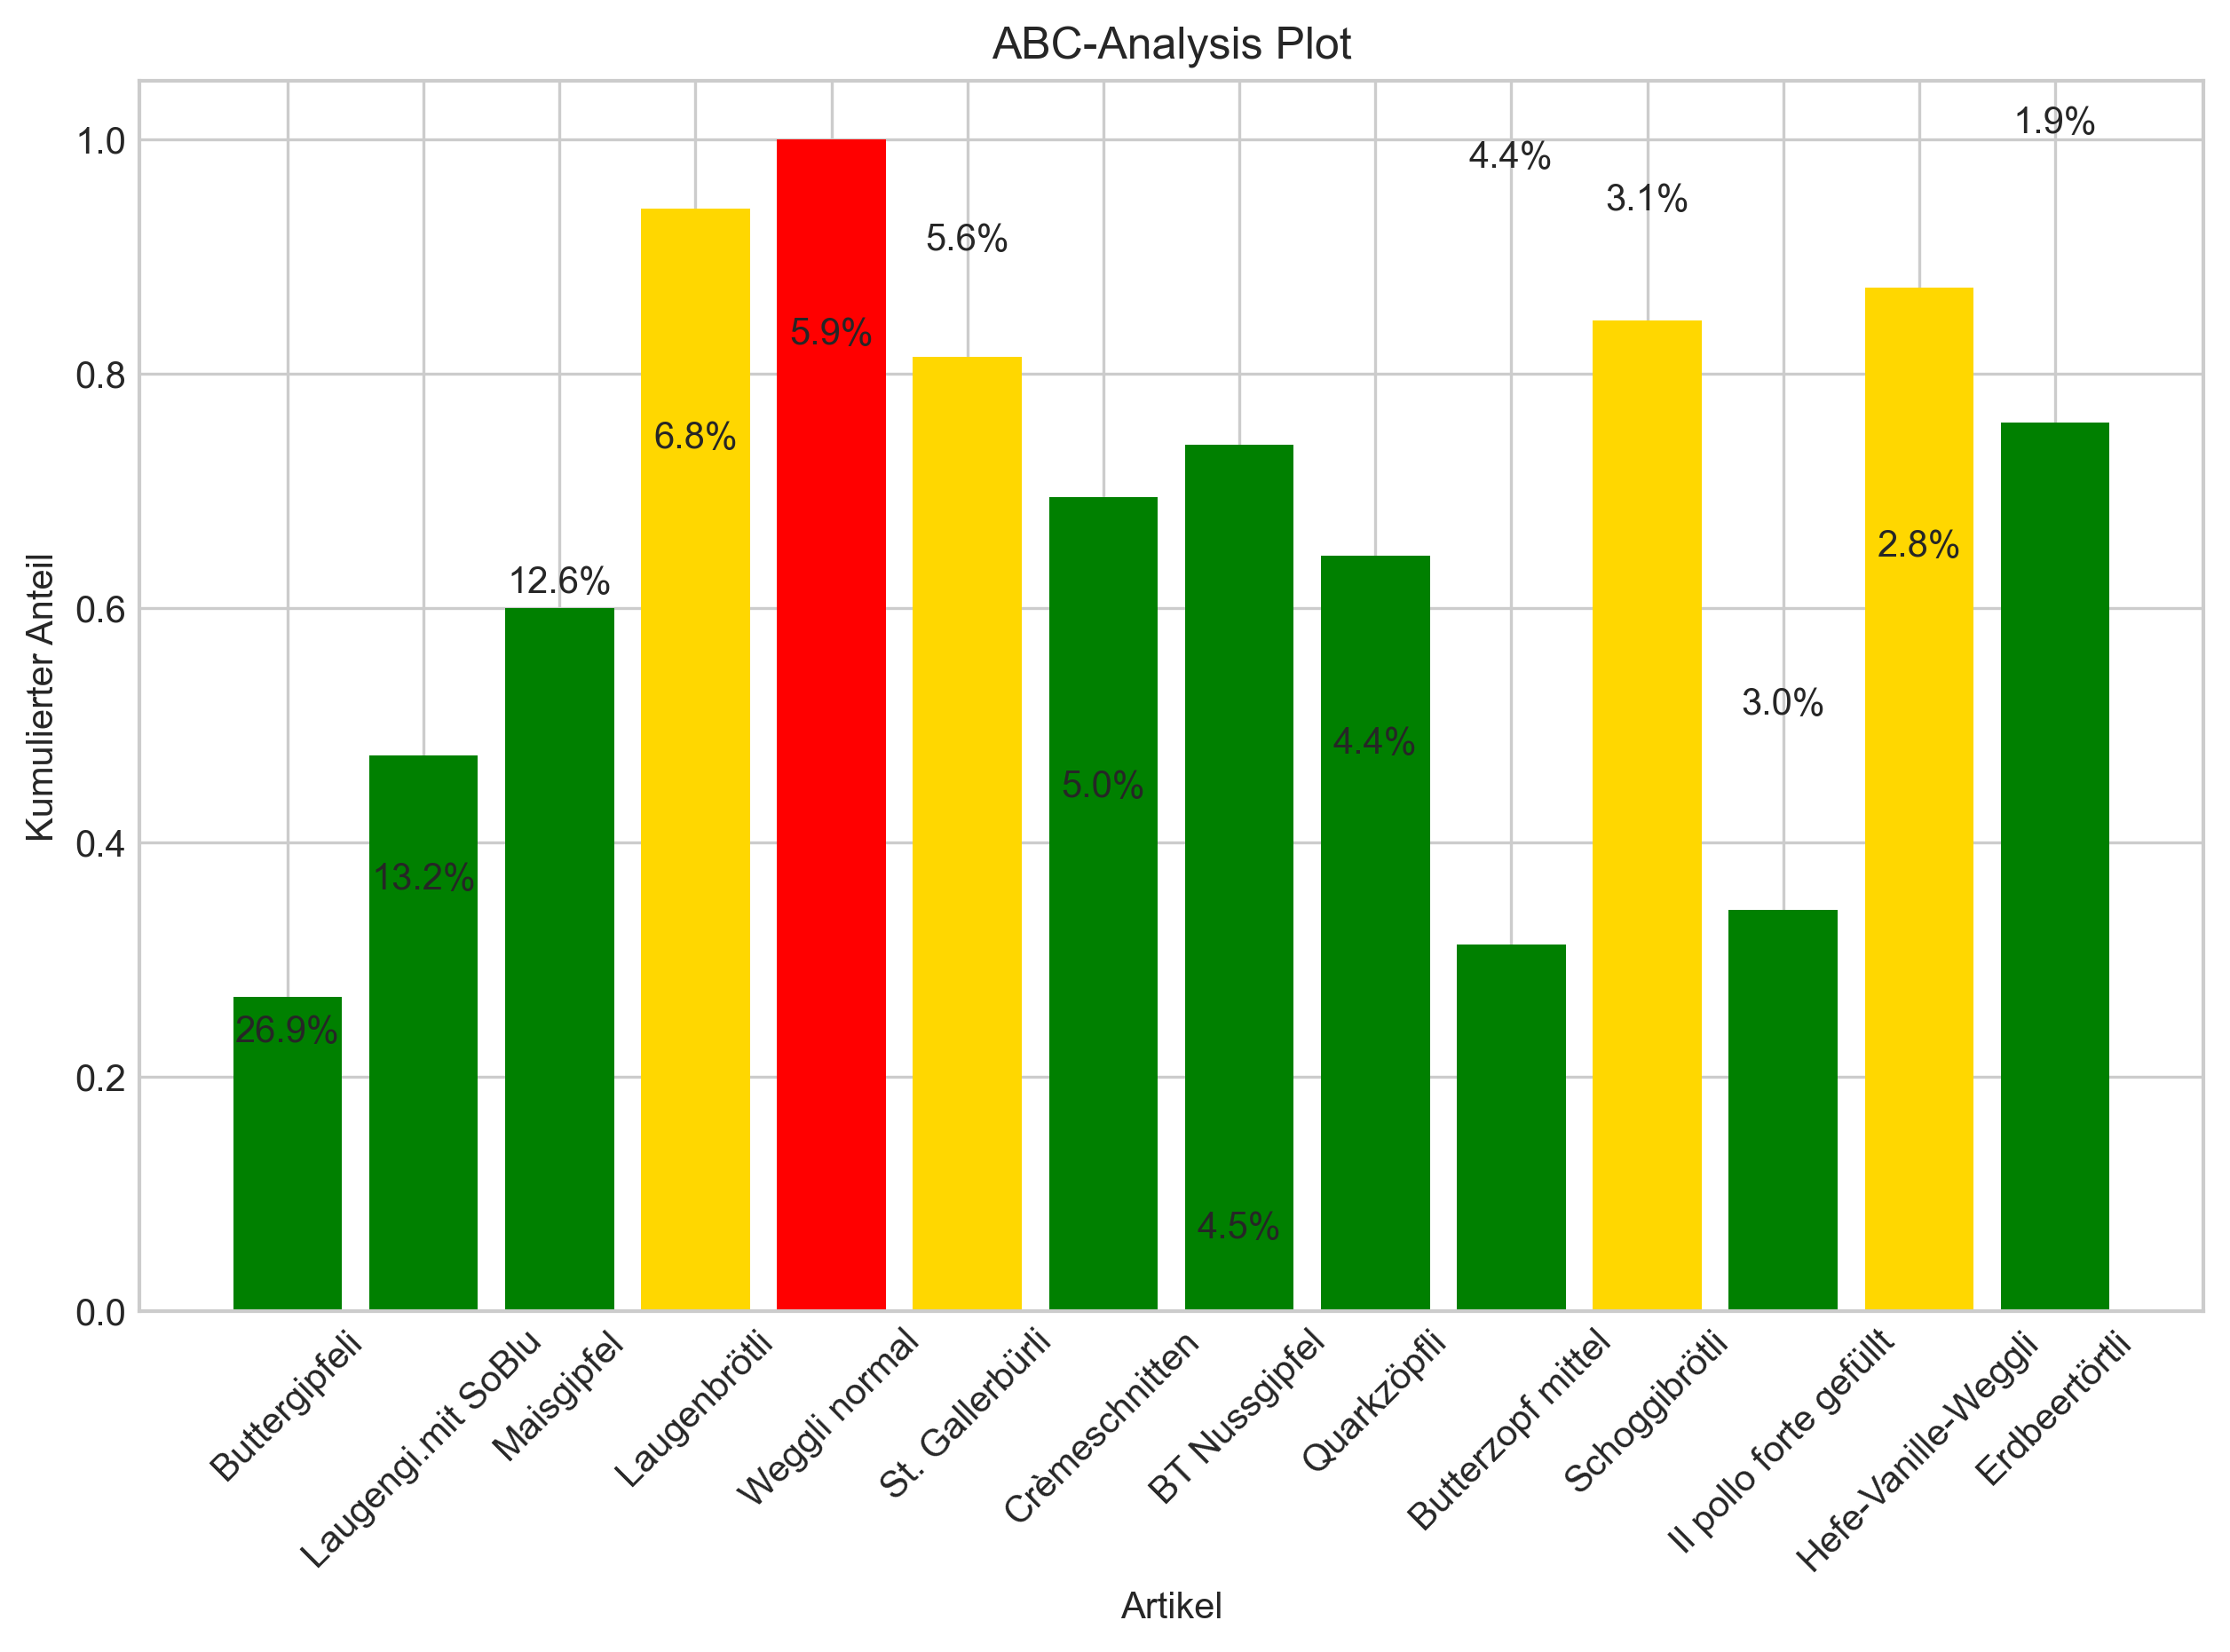

In [57]:
# Calculate the cumulative value and percentage
data_abc_manual['Cumulative_Value'] = data_abc_manual['Menge'].cumsum()
total_value = data_abc_manual['Menge'].sum()
data_abc_manual['Cumulative_Percentage'] = (data_abc_manual['Cumulative_Value'] / total_value)
data_abc_manual['Percentage'] = data_abc_manual['Menge'] / total_value


# Define the ABC classification function
def abc_classification(percentage):
    if percentage <= 0.80:
        return 'A'
    elif percentage <= 0.95:
        return 'B'
    else:
        return 'C'

# Apply the ABC classification to the data
data_abc_manual['Category'] = data_abc_manual['Cumulative_Percentage'].apply(abc_classification)

# Sort the DataFrame by Menge in descending order
data_abc_manual = data_abc_manual.sort_values(by='Menge', ascending=False)

# Plot ABC-Analysis
fig, ax = plt.subplots(figsize=(10, 6), dpi = 300)
ax.bar(data_abc_manual['Artikel'], data_abc_manual['Cumulative_Percentage'], 
       color=['green' if c == 'A' else 'gold' if c == 'B' else 'red' for c in data_abc_manual['Category']])
ax.set_ylabel('Kumulierter Anteil')
ax.set_xlabel('Artikel')
ax.set_title('ABC-Analysis Plot')
plt.xticks(rotation=45)

# Add percentage labels to the bars
for bar, pct in zip(bars, data_abc_manual['Percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(pct), ha='center', va='bottom', )


plt.show()

# 6. High-Level Analyse 

In [58]:
# Hier möchten wir sehen, wie sich der Umsatz/Verkaufsmenge im Verlauf der Jahre entwickelt hat. 

# Zunächst wird der Datensatz umstrukturiert. Wir möchten den Umsatz pro Tag. 
data_2 = data.groupby(['Datum']).agg(Umsatz=('Umsatz',np.sum)).reset_index()
data_2

,Datum,Umsatz
0,2016-01-03,1175.5000
1,2016-01-04,795.1618
2,2016-01-05,512.7082
3,2016-01-06,654.0417
4,2016-01-07,751.9000
...,...,...
2173,2022-02-07,1258.6000
2174,2022-02-08,1417.0500
2175,2022-02-09,1554.7000
2176,2022-02-10,1529.1000


### Umsatz & Menge pro Tag ####

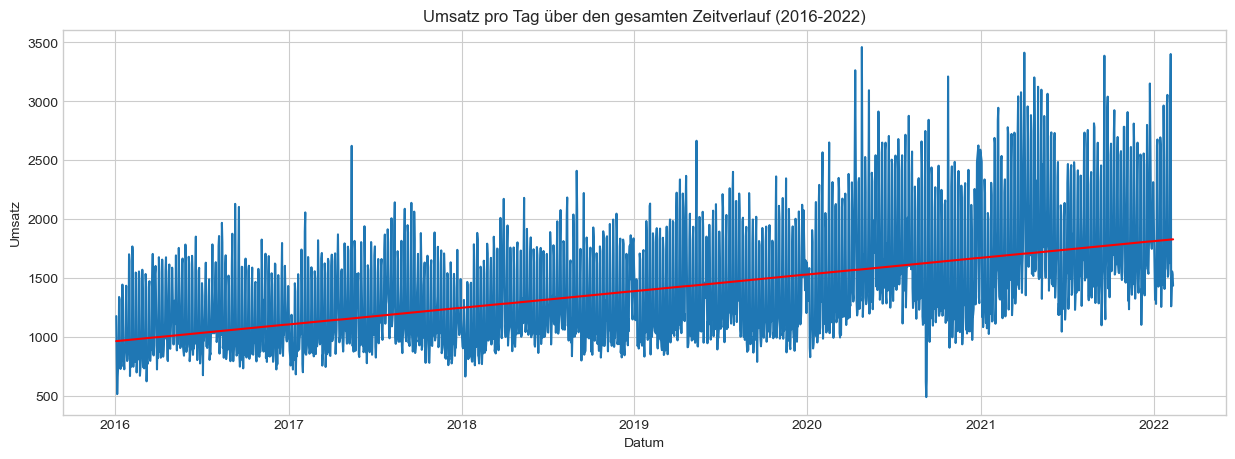

In [59]:
# Visualisierung: Umsatz pro Tag

plt.figure(figsize=(15,5))
plt.plot(data_2['Datum'], data_2['Umsatz'])
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.title('Umsatz pro Tag über den gesamten Zeitverlauf (2016-2022)')

# Trendlinie
z = np.polyfit(data_2.index, data_2['Umsatz'], 1)
p = np.poly1d(z)
plt.plot(data_2['Datum'], p(data_2.index), label='Trendline', color='red')

plt.show()


In [60]:
# Nun möchten wir die Menge pro Tag. 

data_2_menge = data.groupby(['Datum']).agg(Menge=('Menge',np.sum)).reset_index()
data_2_menge

,Datum,Menge
0,2016-01-03,650.0
1,2016-01-04,427.0
2,2016-01-05,306.0
3,2016-01-06,314.0
4,2016-01-07,383.0
...,...,...
2173,2022-02-07,541.0
2174,2022-02-08,571.0
2175,2022-02-09,610.0
2176,2022-02-10,633.0


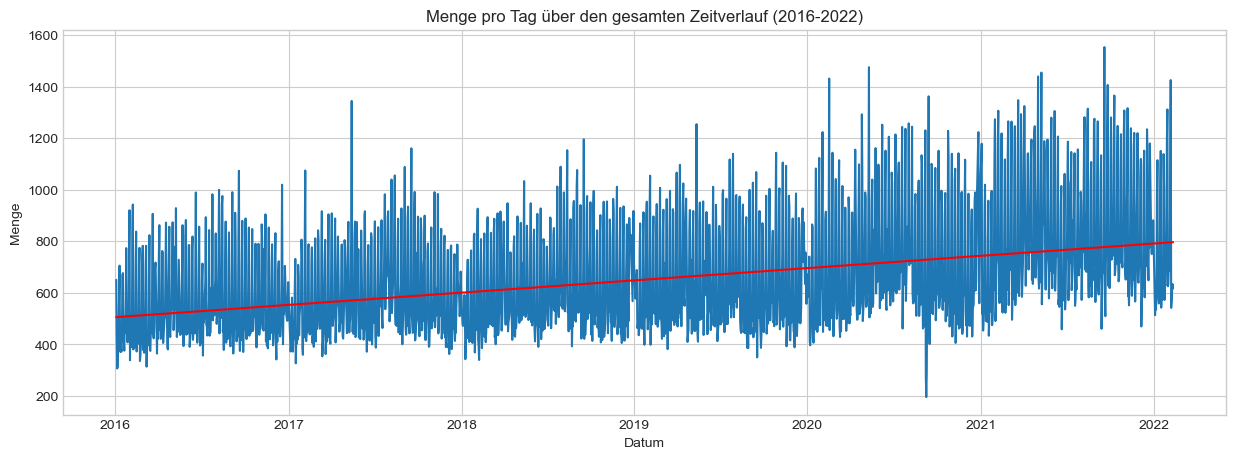

In [61]:
# Visualisierung: Menge pro Tag

plt.figure(figsize=(15,5))
plt.plot(data_2_menge['Datum'], data_2_menge['Menge'])
plt.xlabel('Datum')
plt.ylabel('Menge')
plt.title('Menge pro Tag über den gesamten Zeitverlauf (2016-2022)')

z = np.polyfit(data_2_menge.index, data_2_menge['Menge'], 1)
p = np.poly1d(z)
plt.plot(data_2_menge['Datum'], p(data_2.index), label='Trendline', color='red')

plt.show()


In [62]:
# Für eine bessere Visualisierung wird nun der Umsatz pro Monat aggregiert. 
# Dafür muss der Datensatz entsprechend umgeformt werden.

data_3 = data.groupby(['Datum']).agg(Umsatz=('Umsatz',np.sum)).reset_index()
data_3['Datum'] = pd.to_datetime(data_3["Datum"])  
data_3.set_index('Datum', inplace = True)
data_3_M = data_3.resample('M').sum()
data_3_M 


,Umsatz
Datum,
2016-01-31,28538.4360
2016-02-29,29943.5983
2016-03-31,28968.3602
2016-04-30,35140.1324
2016-05-31,34087.0717
...,...
2021-10-31,61711.0351
2021-11-30,54977.6908
2021-12-31,54113.6879


### Umsatz & Menge pro Monat ###

<AxesSubplot:xlabel='Datum'>

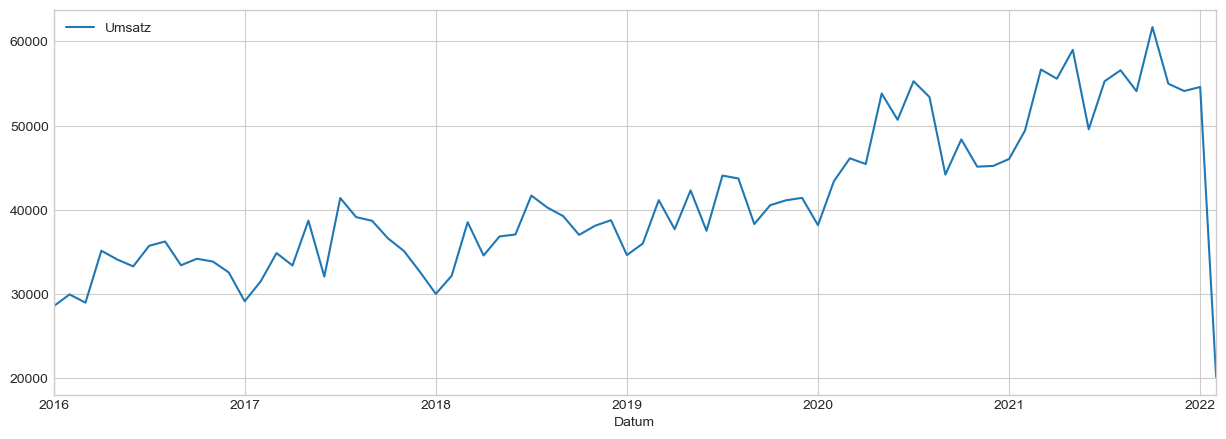

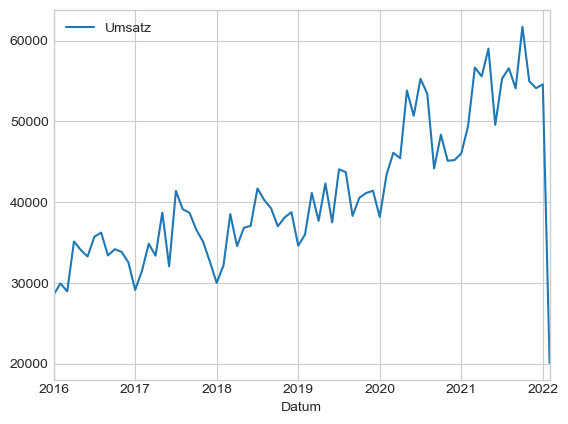

In [63]:
# Visualisierung: Umsatz pro Monat

%matplotlib inline

data_3_M.plot(grid='on', figsize=(15,5))

from datetime import datetime
start_date = datetime(2016, 1, 31)
end_date = datetime(2022, 2, 28)
data_3_M[(start_date <= data_3_M.index) & (data_3_M.index <= end_date)].plot(grid='on')

In [64]:
# Nun wird die verkaufte Menge pro Monat aggregiert. 

data_3_menge = data.groupby(['Datum']).agg(Menge=('Menge',np.sum)).reset_index()
data_3_menge['Datum'] = pd.to_datetime(data_3_menge["Datum"])  
data_3_menge.set_index('Datum', inplace = True)
data_3_M_menge = data_3_menge.resample('M').sum()
data_3_M_menge


,Menge
Datum,
2016-01-31,14649.0
2016-02-29,15167.0
2016-03-31,14380.0
2016-04-30,17237.0
2016-05-31,16743.0
...,...
2021-10-31,27747.0
2021-11-30,24687.0
2021-12-31,23454.0


<AxesSubplot:xlabel='Datum'>

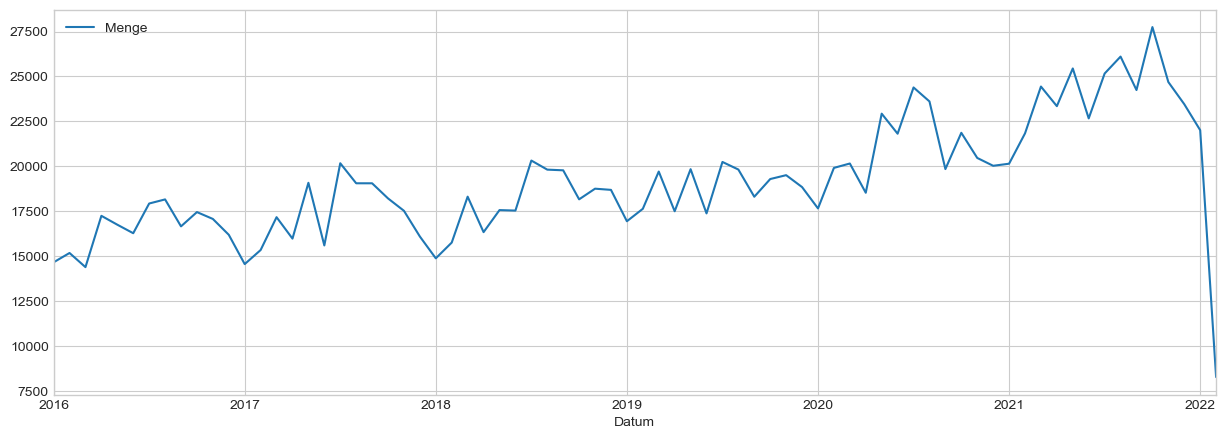

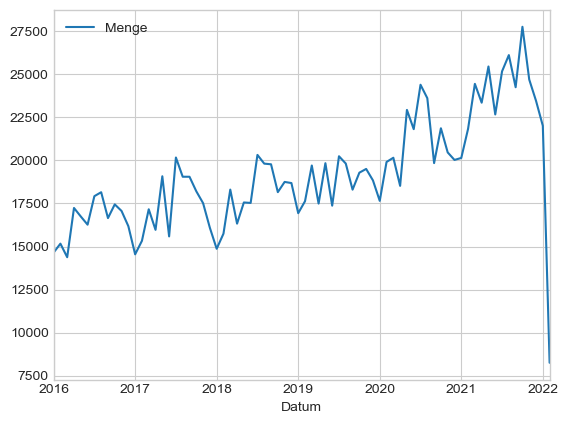

In [65]:
# Visualisierung: Menge pro Monat

%matplotlib inline

data_3_M_menge.plot(grid='on', figsize=(15,5))

from datetime import datetime
start_date = datetime(2016, 1, 31)
end_date = datetime(2022, 2, 28)
data_3_M_menge[(start_date <= data_3_M_menge.index) & (data_3_M_menge.index <= end_date)].plot(grid='on')

In [66]:
# Umsatz pro Monat für ein bestimmtes Jahr (hier: 2016)
%matplotlib inline
# data_3_M.plot(grid='on', figsize=(20,5))
from datetime import datetime
start_date = datetime(2016, 1, 31)
end_date = datetime(2016, 12, 31

data_3_M[(start_date <= data_3_M.index) & (data_3_M.index <= end_date)].plot(grid='on', figsize=(20,5))

SyntaxError: invalid syntax (3558750215.py, line 8)

### Umsatz & Menge pro Woche ###

In [ ]:
# Nun wird der Umsatz pro Woche aggregiert betrachtet.

data_4 = data.groupby(['Datum']).agg(Umsatz=('Umsatz',np.sum)).reset_index()
data_4['Datum'] = pd.to_datetime(data_4["Datum"])  
data_4.set_index('Datum', inplace = True)
data_4_W = data_4.resample('W').sum()
data_4_W 


,Umsatz
Datum,
2016-01-03,1175.5000
2016-01-10,6278.8077
2016-01-17,6518.9359
2016-01-24,6801.5321
2016-01-31,7763.6603
...,...
2022-01-16,13170.1200
2022-01-23,12956.9781
2022-01-30,14365.1982


<AxesSubplot:xlabel='Datum'>

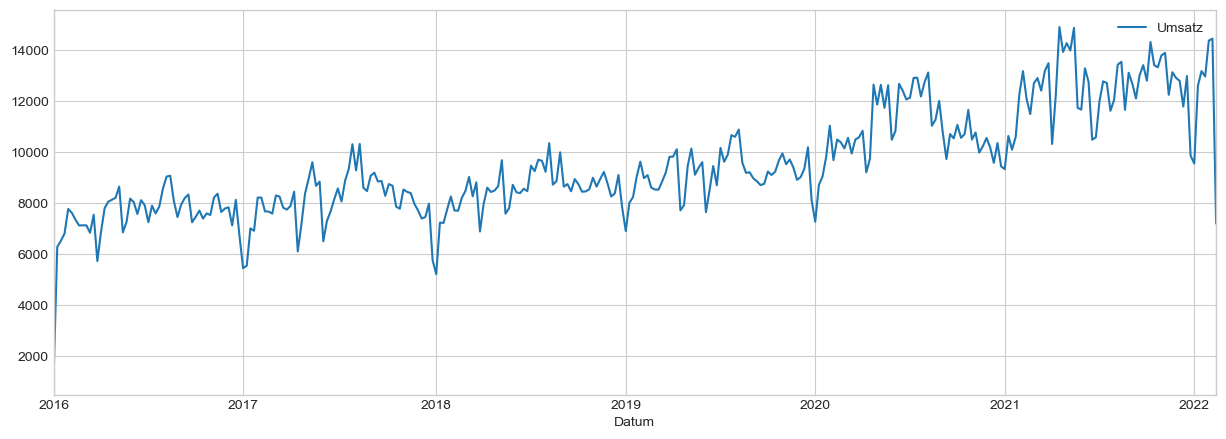

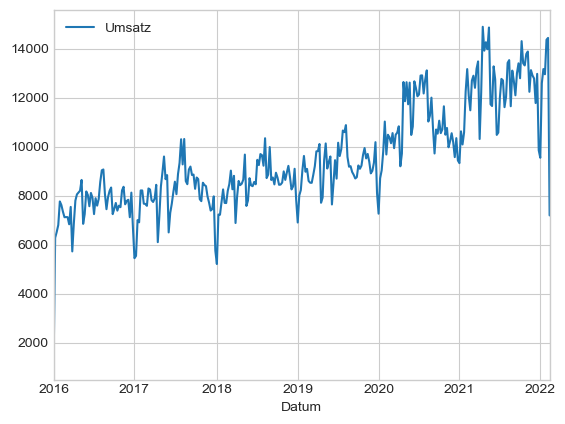

In [ ]:
# Visualisierung: Umsatz pro Woche

%matplotlib inline

data_4_W.plot(grid='on', figsize=(15,5))

from datetime import datetime
start_date = datetime(2016, 1, 3)
end_date = datetime(2022, 2, 13)
data_4_W[(start_date <= data_4_W.index) & (data_4_W.index <= end_date)].plot(grid='on')

In [ ]:
# Nun wird die verkaufte Menge pro Woche aggregiert betrachtet.

data_4_menge = data.groupby(['Datum']).agg(Menge=('Menge',np.sum)).reset_index()
data_4_menge['Datum'] = pd.to_datetime(data_4_menge["Datum"])  
data_4_menge.set_index('Datum', inplace = True)
data_4_W_menge = data_4_menge.resample('W').sum()
data_4_W_menge

,Menge
Datum,
2016-01-03,650.0
2016-01-10,3202.0
2016-01-17,3328.0
2016-01-24,3488.0
2016-01-31,3981.0
...,...
2022-01-16,5279.0
2022-01-23,5195.0
2022-01-30,5908.0


<AxesSubplot:xlabel='Datum'>

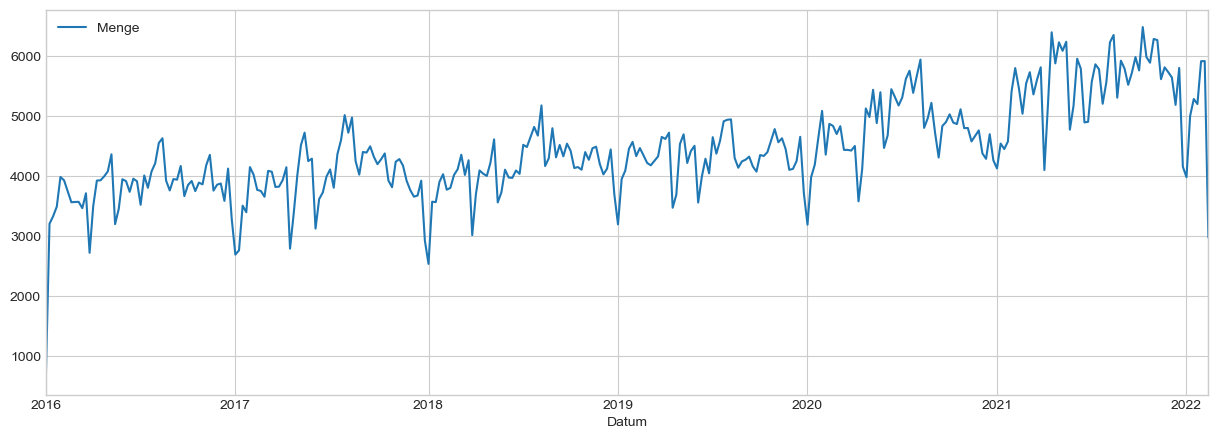

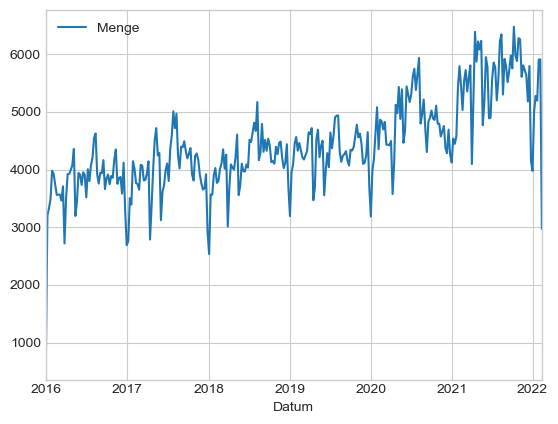

In [ ]:
# Visualisierung: Menge pro Woche
%matplotlib inline

data_4_W_menge.plot(grid='on', figsize=(15,5))

from datetime import datetime
start_date = datetime(2016, 1, 3)
end_date = datetime(2022, 2, 13)
data_4_W_menge[(start_date <= data_4_W_menge.index) & (data_4_W_menge.index <= end_date)].plot(grid='on')


### Menge pro Jahr ###

In [ ]:
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Stückpreis
247122,Laugengi.mit SoBlu,3.0,0.12,130.0,0.0,13.841667,1.4,170.166667,2023-03-27 13:00:38,13,2018-05-19,Saturday,0.04
217231,Quarkzöpfli,1.0,0.10,22.0,0.0,0.866667,0.0,30.208333,2023-03-27 08:57:27,8,2018-02-09,Friday,0.10
4071,Weggli normal,1.0,0.10,0.0,0.0,NaN,0.2,NaN,2023-03-27 17:10:23,17,2016-01-19,Tuesday,0.10
86256,Weggli normal,1.0,0.10,0.0,0.2,6.137500,17.6,47.166667,2023-03-27 09:19:42,9,2016-11-10,Thursday,0.10
47706,Maisgipfel,1.0,0.20,0.0,0.2,20.733333,0.4,257.291667,2023-03-27 07:40:12,7,2016-06-29,Wednesday,0.20


In [ ]:
data.index

Int64Index([247122, 217231,   4071,  86256,  47706, 209041, 128035, 170391,
            274185, 109701,
            ...
            717214, 720014, 717231, 717232, 717236, 717238, 723066, 723109,
            717313, 721662],
           dtype='int64', length=719185)

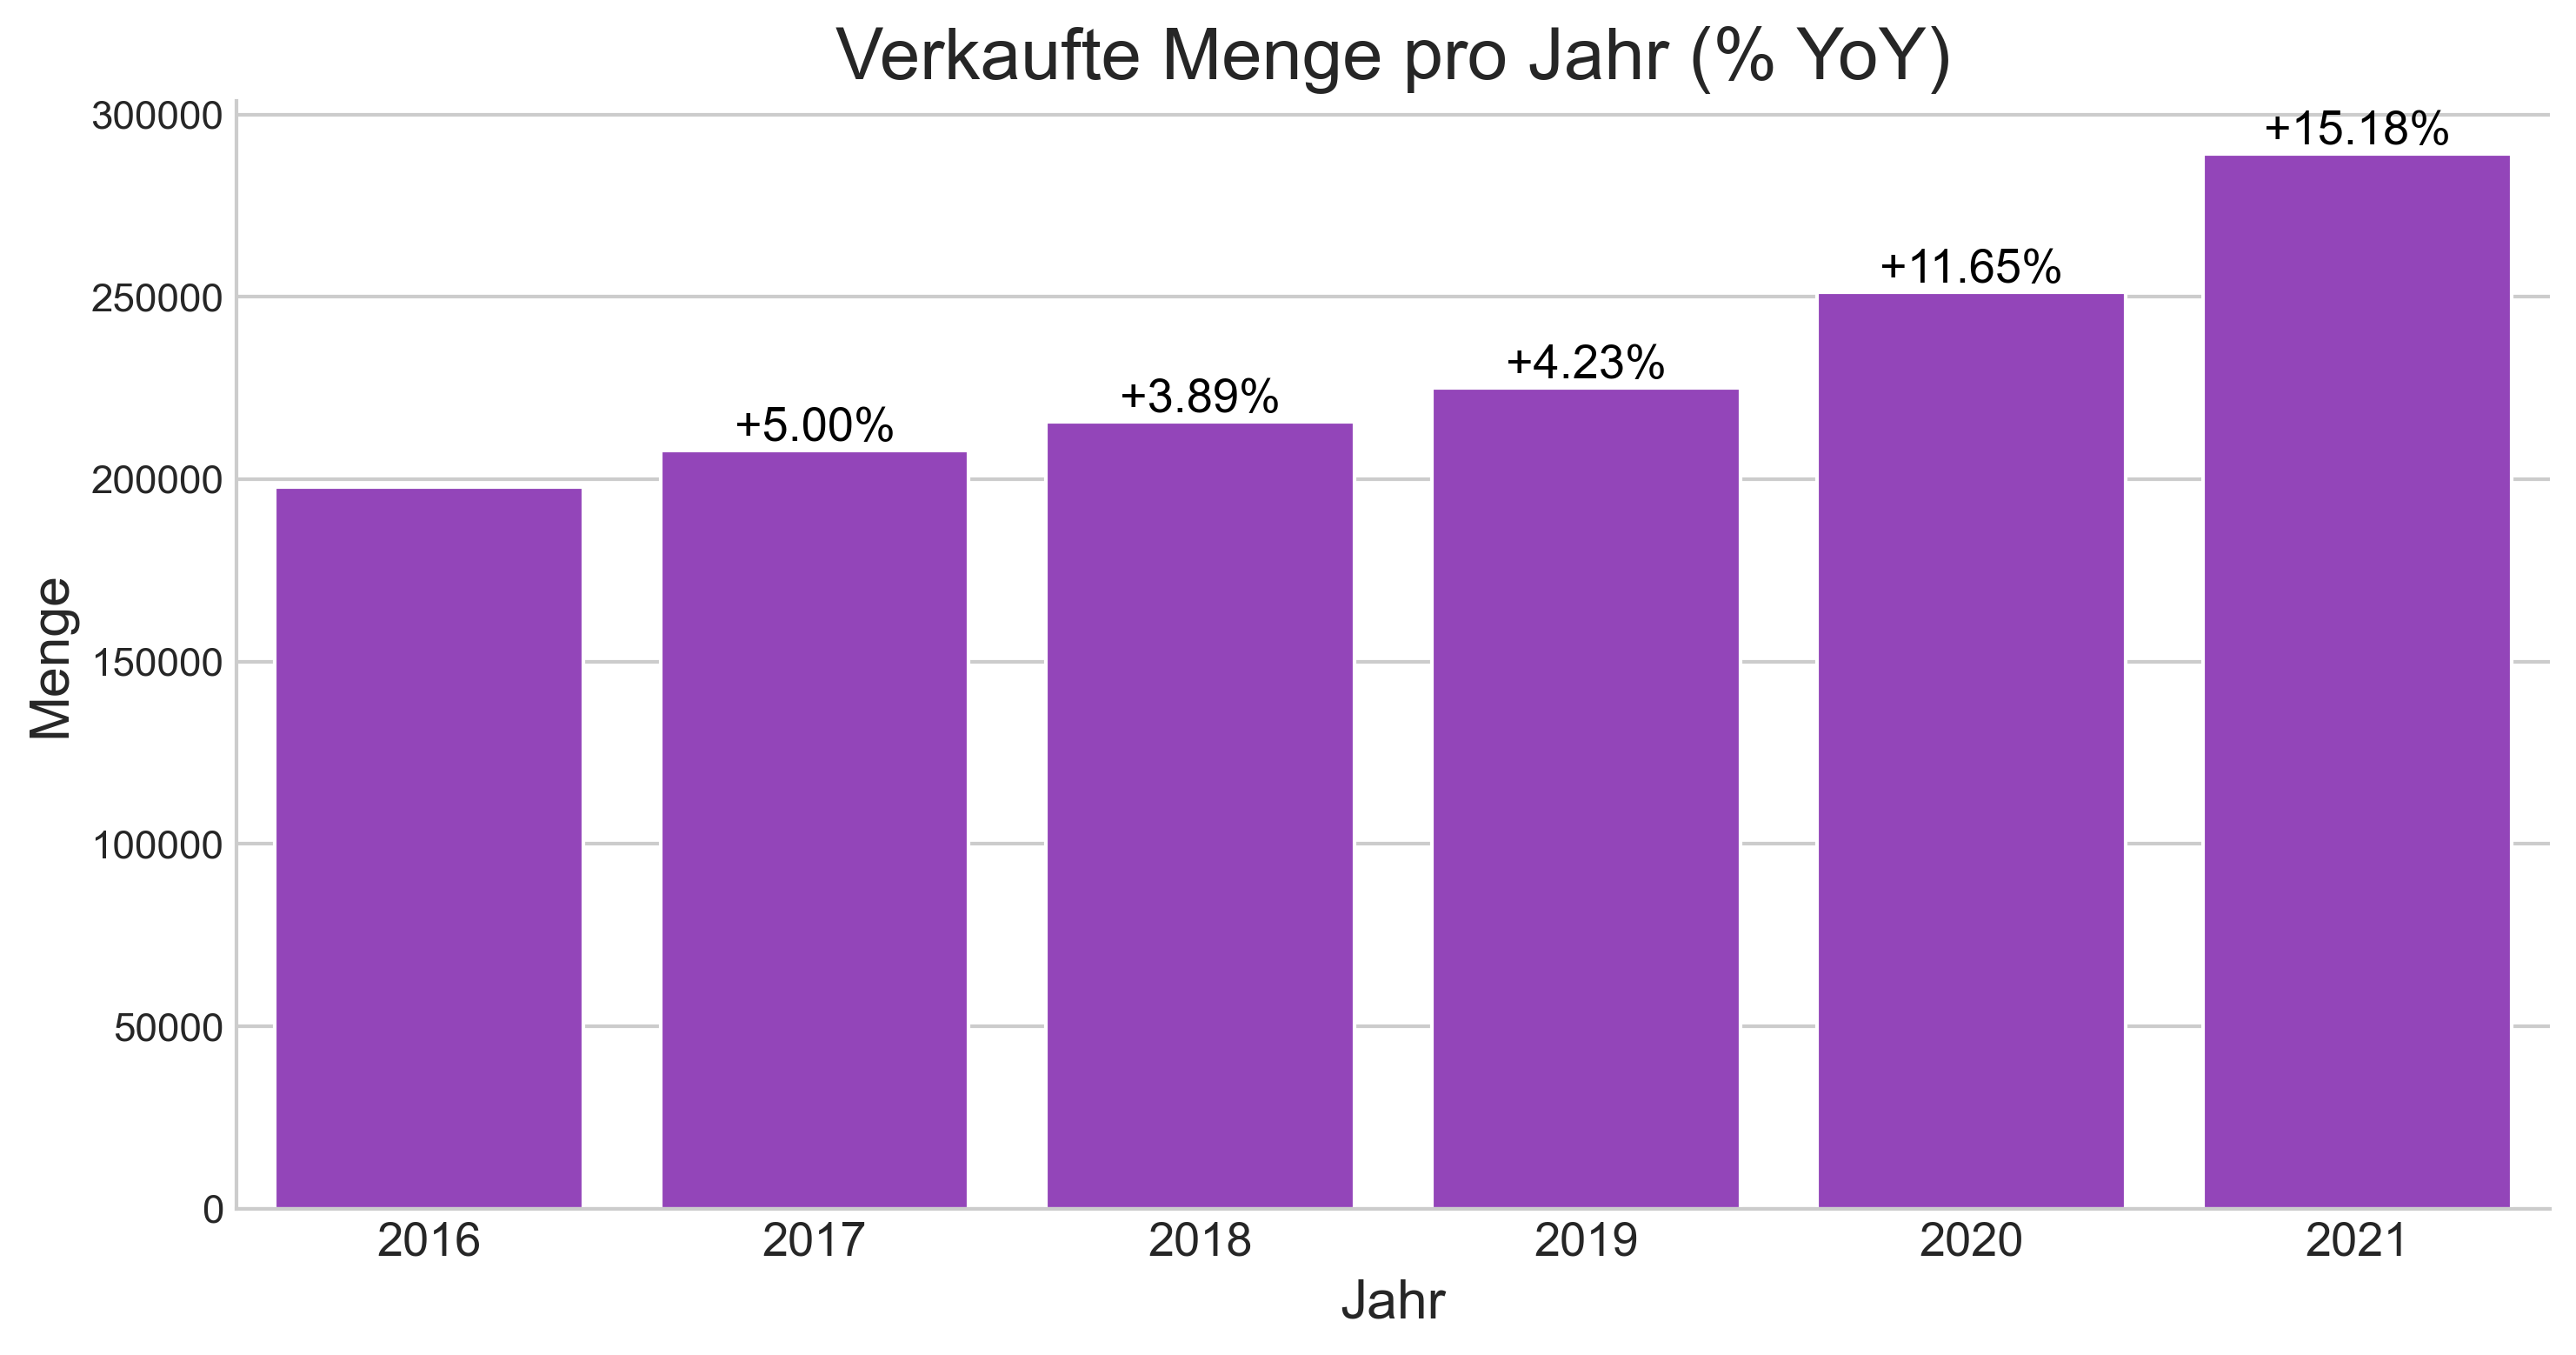

In [ ]:
import numpy as np

# Balkendiagramm für die Menge pro Jahr
data_Jahr = data.groupby(data.Datum.dt.year).agg(Menge=('Menge', np.sum)).reset_index()
data_Jahr = data_Jahr[data_Jahr['Datum'] != 2022]

# Calculate the year-over-year percentage change
data_Jahr['YoY'] = data_Jahr['Menge'].pct_change() * 100

plt_jahr = sns.catplot(kind='bar', data=data_Jahr, x='Datum', y='Menge', 
                       height=5, aspect=2, color='darkorchid')

# Set the title and labels
plt.title('Verkaufte Menge pro Jahr (% YoY)', size=20)
plt.xticks(size=13)
plt.xlabel('Jahr', size=15)
plt.ylabel('Menge', size=15)

# Annotate the bars with YoY percentage change
ax = plt.gca()
for p, yoy in zip(ax.patches, data_Jahr['YoY']):
    if not np.isnan(yoy):
        ax.annotate(f'{yoy:+.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', size=13, color='black')

# Graph exportieren
plt.savefig('Verkaufte Menge pro Jahr (% YoY).png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
data_Jahr

,Datum,Menge,YoY
0,2016,197856.0,NaN
1,2017,207740.6,4.995856
2,2018,215814.0,3.886289
3,2019,224936.0,4.226788
4,2020,251135.8,11.647669
5,2021,289246.5,15.175335


# Weitere Analysen #

### Analyse des Preisverlaufs ###
Marinela -

In [68]:
# Stückpreis berechnet
data["Stückpreis"] = pd.to_numeric(data["Umsatz"] / data["Menge"]).apply(lambda x: '{:.2f}'.format(x))

# Sortieren nach Stückpreis
data_preis = data.sort_values(by='Stückpreis', ascending=True)

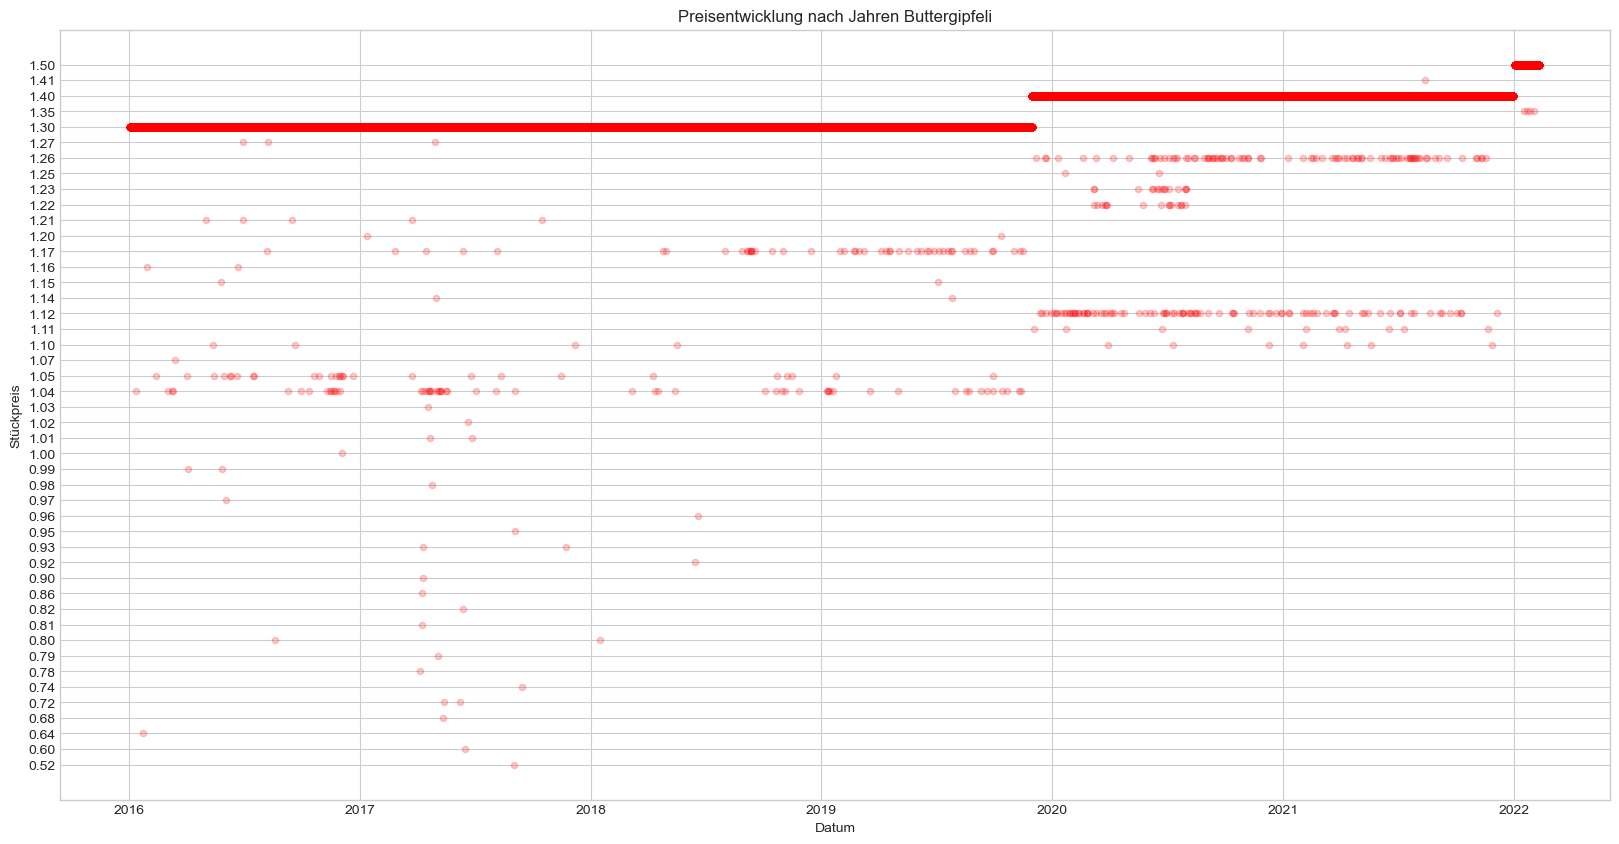

In [70]:
# Plot mit Preisentwicklung von BT Nussgipfeln über die Jahre
data_preis.loc[data["Artikel"] == "Buttergipfeli"].plot(kind='scatter', x='Datum', y='Stückpreis', alpha=0.2, figsize=(20,10), color='red', title='Preisentwicklung nach Jahren Buttergipfeli')

# Exportieren des Plots als PNG
plt.savefig('Preisentwicklung nach Jahren Buttergipfeli.png', dpi=500, bbox_inches='tight')

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_74486/3839762170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maisgipfel_data['Datum'] = pd.to_datetime(maisgipfel_data['Datum'])


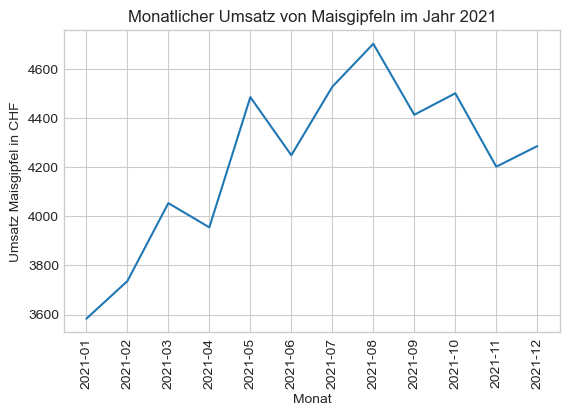

In [ ]:
# Umsatz Maisgipfel pro Monat

data['Datum'] = pd.to_datetime(data['Datum'])
jahr = 2021

maisgipfel_data = data[(data['Artikel'] == 'Maisgipfel') & (data['Datum'].dt.year == jahr)]
maisgipfel_data['Datum'] = pd.to_datetime(maisgipfel_data['Datum'])

maisgipfel_monthly_revenue = maisgipfel_data.groupby(maisgipfel_data['Datum'].dt.strftime('%Y-%m'))['Umsatz'].sum()
plt.plot(maisgipfel_monthly_revenue.index, maisgipfel_monthly_revenue.values)
plt.xlabel('Monat')
plt.ylabel('Umsatz Maisgipfel in CHF')
plt.title(f'Monatlicher Umsatz von Maisgipfeln im Jahr {jahr}')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_74486/586947192.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maisgipfel_data['Datum'] = pd.to_datetime(maisgipfel_data['Datum'])


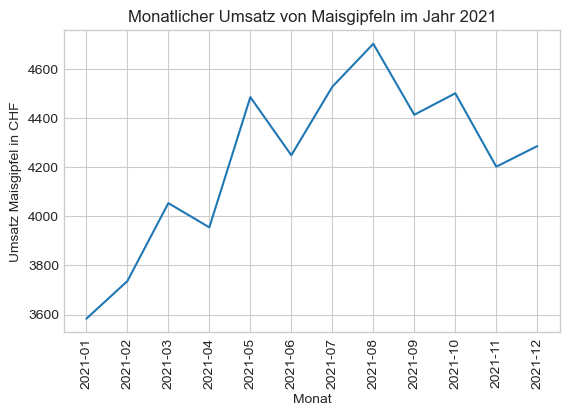

In [ ]:
# Umsatz Maisgipfel pro Monat

data['Datum'] = pd.to_datetime(data['Datum'])
jahr = 2021

maisgipfel_data = data[(data['Artikel'] == 'Maisgipfel') & (data['Datum'].dt.year == jahr)]
maisgipfel_data['Datum'] = pd.to_datetime(maisgipfel_data['Datum'])

maisgipfel_monthly_revenue = maisgipfel_data.groupby(maisgipfel_data['Datum'].dt.strftime('%Y-%m'))['Umsatz'].sum()
plt.plot(maisgipfel_monthly_revenue.index, maisgipfel_monthly_revenue.values)
plt.xlabel('Monat')
plt.ylabel('Umsatz Maisgipfel in CHF')
plt.title(f'Monatlicher Umsatz von Maisgipfeln im Jahr {jahr}')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()


/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_74486/840693886.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buttergipfel_data['Datum'] = pd.to_datetime(buttergipfel_data['Datum'])


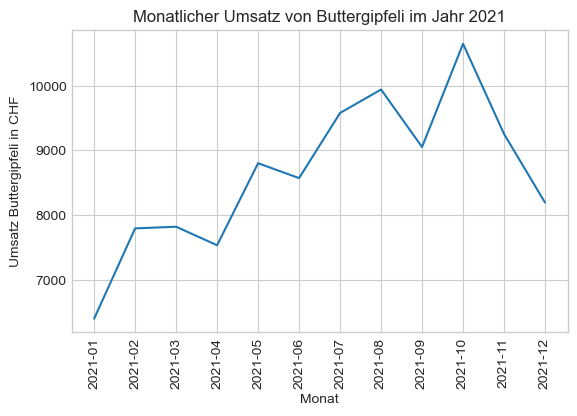

In [ ]:
# Umsatz Buttergipfeli pro Monat

data['Datum'] = pd.to_datetime(data['Datum'])
jahr = 2021

buttergipfel_data = data[(data['Artikel'] == 'Buttergipfeli') & (data['Datum'].dt.year == jahr)]
buttergipfel_data['Datum'] = pd.to_datetime(buttergipfel_data['Datum'])

buttergipfel_monthly_revenue = buttergipfel_data.groupby(buttergipfel_data['Datum'].dt.strftime('%Y-%m'))['Umsatz'].sum()
plt.plot(buttergipfel_monthly_revenue.index, buttergipfel_monthly_revenue.values)
plt.xlabel('Monat')
plt.ylabel('Umsatz Buttergipfeli in CHF')
plt.title(f'Monatlicher Umsatz von Buttergipfeli im Jahr {jahr}')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_74486/3240120261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laugengipfelimitsonnenblumen_data['Datum'] = pd.to_datetime(laugengipfelimitsonnenblumen_data['Datum'])


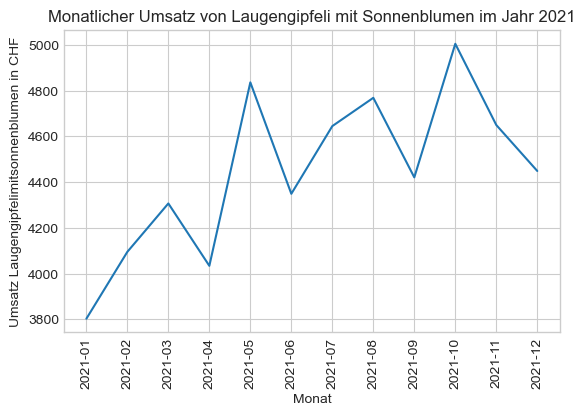

In [ ]:
# Umsatz Laugengipfeli mit Sonnenblumen pro Monat

data['Datum'] = pd.to_datetime(data['Datum'])
jahr = 2021

laugengipfelimitsonnenblumen_data = data[(data['Artikel'] == 'Laugengi.mit SoBlu') & (data['Datum'].dt.year == jahr)]
laugengipfelimitsonnenblumen_data['Datum'] = pd.to_datetime(laugengipfelimitsonnenblumen_data['Datum'])

laugengipfelimitsonnenblumen_monthly_revenue = laugengipfelimitsonnenblumen_data.groupby(laugengipfelimitsonnenblumen_data['Datum'].dt.strftime('%Y-%m'))['Umsatz'].sum()
plt.plot(laugengipfelimitsonnenblumen_monthly_revenue.index, laugengipfelimitsonnenblumen_monthly_revenue.values)
plt.xlabel('Monat')
plt.ylabel('Umsatz Laugengipfelimitsonnenblumen in CHF')
plt.title(f'Monatlicher Umsatz von Laugengipfeli mit Sonnenblumen im Jahr {jahr}')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_74486/3462990816.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laugenbroetli_data['Datum'] = pd.to_datetime(laugenbroetli_data['Datum'])


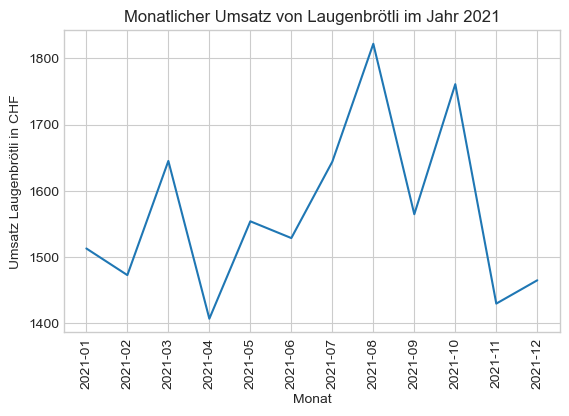

In [ ]:
# Umsatz Laugenbrötli pro Monat

data['Datum'] = pd.to_datetime(data['Datum'])
jahr = 2021

laugenbroetli_data = data[(data['Artikel'] == 'Laugenbrötli') & (data['Datum'].dt.year == jahr)]
laugenbroetli_data['Datum'] = pd.to_datetime(laugenbroetli_data['Datum'])

laugenbroetli_monthly_revenue = laugenbroetli_data.groupby(laugenbroetli_data['Datum'].dt.strftime('%Y-%m'))['Umsatz'].sum()
plt.plot(laugenbroetli_monthly_revenue.index, laugenbroetli_monthly_revenue.values)
plt.xlabel('Monat')
plt.ylabel('Umsatz Laugenbrötli in CHF')
plt.title(f'Monatlicher Umsatz von Laugenbrötli im Jahr {jahr}')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()

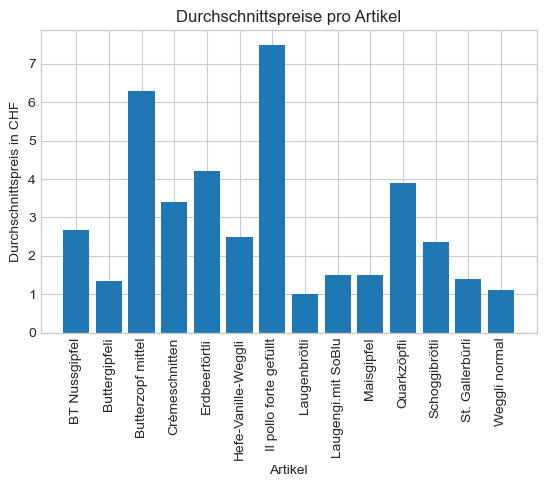

Artikel
BT Nussgipfel             2.680586
Buttergipfeli             1.341264
Butterzopf mittel         6.285463
Crèmeschnitten            3.393380
Erdbeertörtli             4.208915
Hefe-Vanille-Weggli       2.492741
Il pollo forte gefüllt    7.497081
Laugenbrötli              0.998934
Laugengi.mit SoBlu        1.501443
Maisgipfel                1.501425
Quarkzöpfli               3.890047
Schoggibrötli             2.354931
St. Gallerbürli           1.398215
Weggli normal             1.099170
dtype: float64


In [ ]:
# Durchschnittspreise pro Artikel
product_prices = data.groupby('Artikel')['Umsatz'].sum() / data.groupby('Artikel')['Menge'].sum()

plt.bar(product_prices.index, product_prices.values)


plt.title('Durchschnittspreise pro Artikel')
plt.xlabel('Artikel')
plt.ylabel('Durchschnittspreis in CHF')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.show()

print(product_prices)

### Durchschnittspreis und Totalumsatz pro Artikel ###

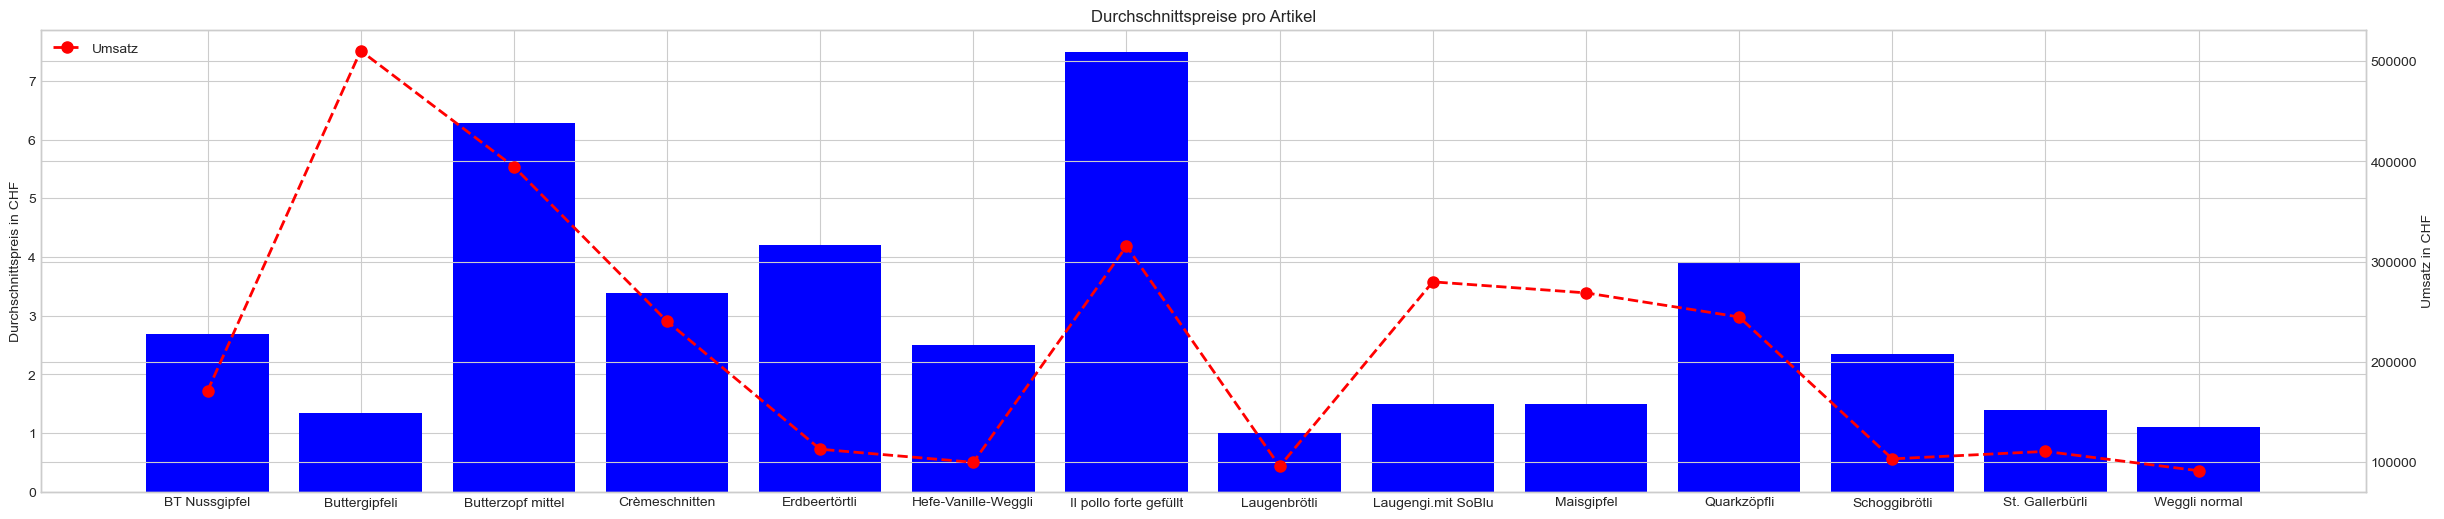

In [ ]:
# Durschnitsspreis und Totalumsatz pro Artikel
product_prices = data.groupby('Artikel')['Umsatz'].sum() / data.groupby('Artikel')['Menge'].sum()
umsatz_pro_artikel = data.groupby('Artikel')['Umsatz'].sum()

# Grösse Plot definieren
fig = plt.figure(figsize=(30, 6))

# Linke y-Achse und die Balken definieren
ax1 = fig.add_subplot(111)
ax1.bar(product_prices.index, product_prices.values, color='b')
ax1.set_ylabel('Durchschnittspreis in CHF')

# Rechte y-Achse und die Linie definieren
ax2 = ax1.twinx()
ax2.plot(product_prices.index, umsatz_pro_artikel.values, color='r', marker='o', linestyle='dashed', linewidth=2, markersize=8)
ax2.set_ylabel('Umsatz in CHF')

# Beschriftung x-Achse und Titel definieren
plt.title('Durchschnittspreise pro Artikel')

# Rotationswinkel der x-Achse definieren
plt.xticks(rotation=45, ha='right')
plt.legend(['Umsatz', 'Durchschnittspreis'], loc='upper left')

# Plot anzeigen
plt.show()

Number of Buttergipfeli orders on 12.04.2021: 85.0
Total amount of Buttergipfeli sold on 12.04.2021: 170.0


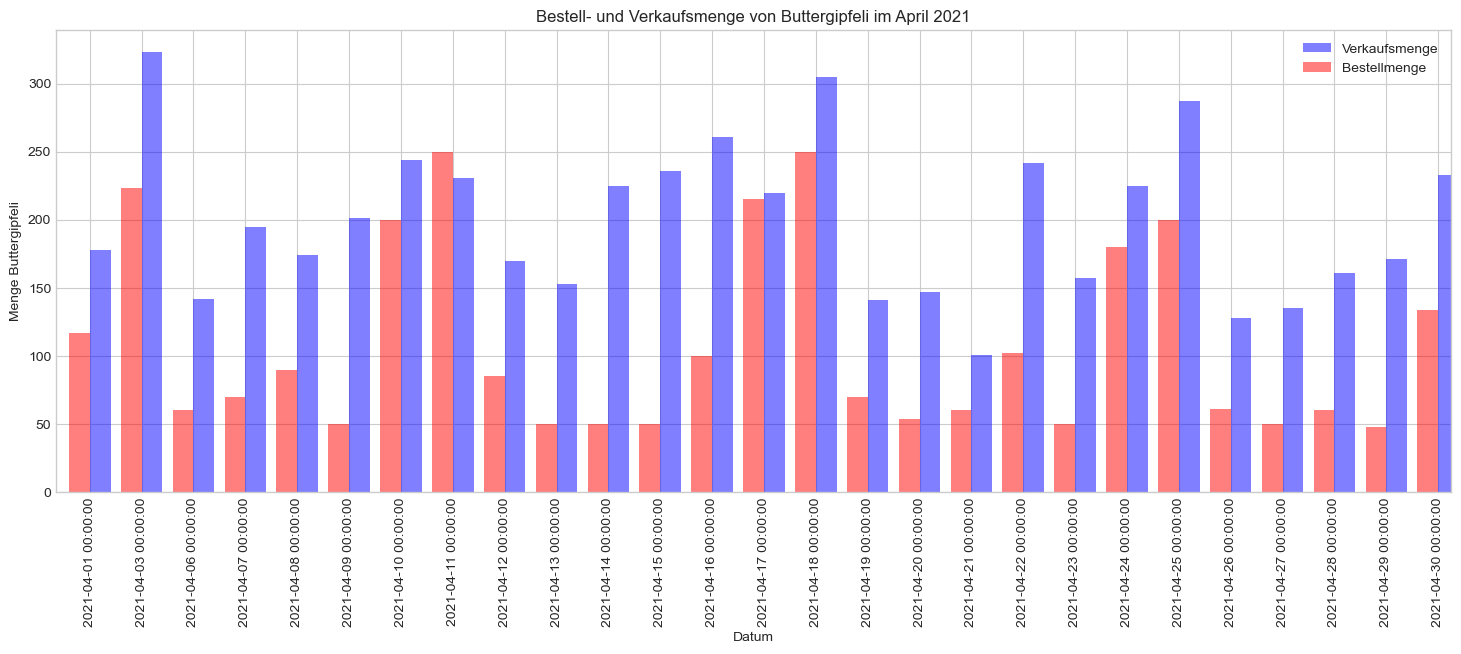

In [ ]:
# Column Datum in Datetime umwandeln
data['Datum'] = pd.to_datetime(data['Datum'], format='%Y-%m-%d')

# Daten von Buttergipfeli nach 12.04.2021 filtern
buttergipfeli_data = data[(data['Artikel'] == 'Buttergipfeli') & (data['Datum'] == '2021-04-12')]

# Ersten Eintrag von Bestellungen ausgeben
buttergipfeli_orders_12042021 = buttergipfeli_data['Bestellungen'].iloc[0]

# Den Gesamtumsatz von Buttergipfeli ausgeben
buttergipfeli_sold_12042021 = buttergipfeli_data['Menge'].sum()

# Resultate ausgeben
print(f"Number of Buttergipfeli orders on 12.04.2021: {buttergipfeli_orders_12042021}")
print(f"Total amount of Buttergipfeli sold on 12.04.2021: {buttergipfeli_sold_12042021}")

# Column Datum in Datetime umwandeln
data['Datum'] = pd.to_datetime(data['Datum'], format='%Y-%m-%d')

# Daten filtern nach April 2021
start_date = '2021-04-01'
end_date = '2021-04-30'
april_data = data[(data['Datum'] >= start_date) & (data['Datum'] <= end_date)]

# Anzahl Bestellungen und Verkaufsmenge von Buttergipfeli ausgeben
sales_by_day = april_data[april_data['Artikel'] == 'Buttergipfeli'].groupby('Datum')['Menge'].sum()
orders_by_day = april_data[april_data['Artikel'] == 'Buttergipfeli'].groupby('Datum')['Bestellungen'].mean()

# Resultat in plot und bar chart ausgeben
fig, ax = plt.subplots(figsize=(18, 6))
sales_by_day.plot(kind='bar', ax=ax, color='blue', alpha=0.5, width=0.4, position=0, label='Verkaufsmenge')
orders_by_day.plot(kind='bar', ax=ax, color='red', alpha=0.5, width=0.4, position=1, label='Bestellmenge')

# Beschriftungen und Titel definieren
ax.set_xlabel('Datum')
ax.set_ylabel('Menge Buttergipfeli')
ax.set_title('Bestell- und Verkaufsmenge von Buttergipfeli im April 2021')

# Chart anzeigen
plt.legend()
plt.show()

In [ ]:
buttergipfel_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26153 entries, 698936 to 653369
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Artikel                      26153 non-null  object        
 1   Menge                        26153 non-null  float64       
 2   Umsatz                       26153 non-null  float64       
 3   Bestellungen                 26153 non-null  float64       
 4   Niederschlag                 26054 non-null  float64       
 5   Temperatur Schnitt Tag       26153 non-null  float64       
 6   Niederschlag Summe Tag       26153 non-null  float64       
 7   Globalstrahlung Schnitt Tag  26153 non-null  float64       
 8   Uhrzeit                      26153 non-null  object        
 9   Stunde                       26153 non-null  int64         
 10  Datum                        26153 non-null  datetime64[ns]
 11  Wochentag                    26153 

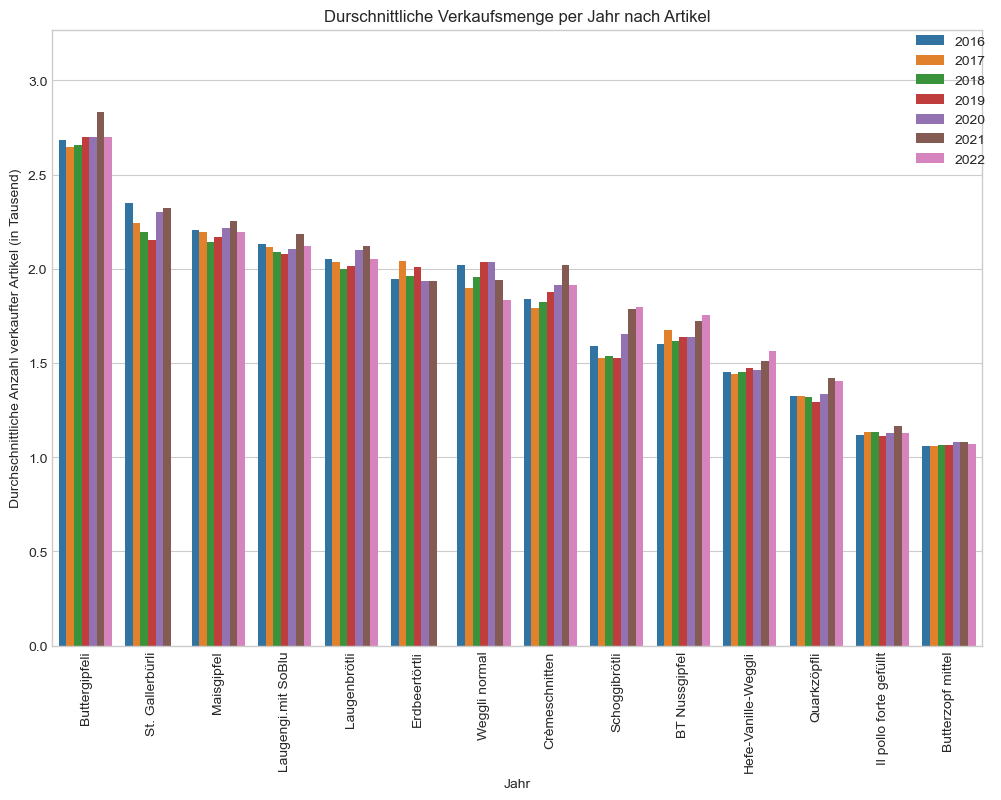

In [ ]:
#Gruppiere die Daten nach Artikel und Jahr und berechne den Mittelwert der Menge-Spalte
grouped_data = data.groupby(['Artikel', data['Datum'].dt.year])['Menge'].mean()

# Konvertieren der gruppierten Daten in Dataframe
data_grouped = grouped_data.reset_index(name='avg_items_sold')

data_grouped_sorted = data_grouped.sort_values(by='avg_items_sold', ascending=False)
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x='Artikel', y='avg_items_sold', hue='Datum', data=data_grouped_sorted)
ax.set(title='Durschnittliche Verkaufsmenge per Jahr nach Artikel', xlabel='Jahr', ylabel='Durchschnittliche Anzahl verkaufter Artikel (in Tausend)')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylim([0, ax.get_ylim()[1]*1.1]) 
ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.show()

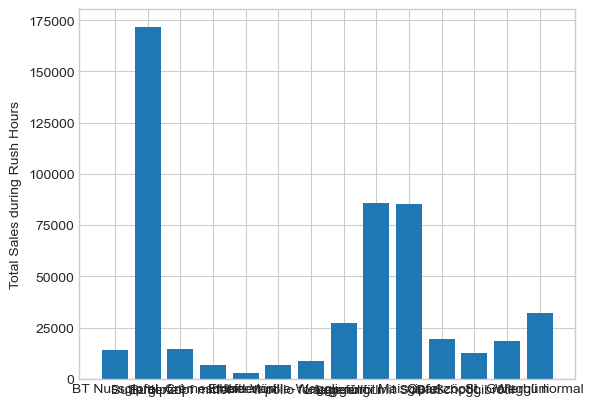

In [ ]:
# Uhrzeit in Stringformat umwandeln
data['Uhrzeit'] = data['Uhrzeit'].astype(str)

# Datenset nach Stosszeiten filtern

rush_hour_data = data[(data['Uhrzeit'] >= '07:00:00') & (data['Uhrzeit'] <= '09:00:00')]

# Daten nach Artikel gruppieren und Summe der Menge berechnen
sales_by_product = rush_hour_data.groupby('Artikel')['Menge'].sum()

# Bar plot  erstellen
plt.bar(np.arange(len(sales_by_product)), sales_by_product.values)
plt.xticks(np.arange(len(sales_by_product)), sales_by_product.index)
plt.ylabel('Total Sales during Rush Hours')
plt.show()


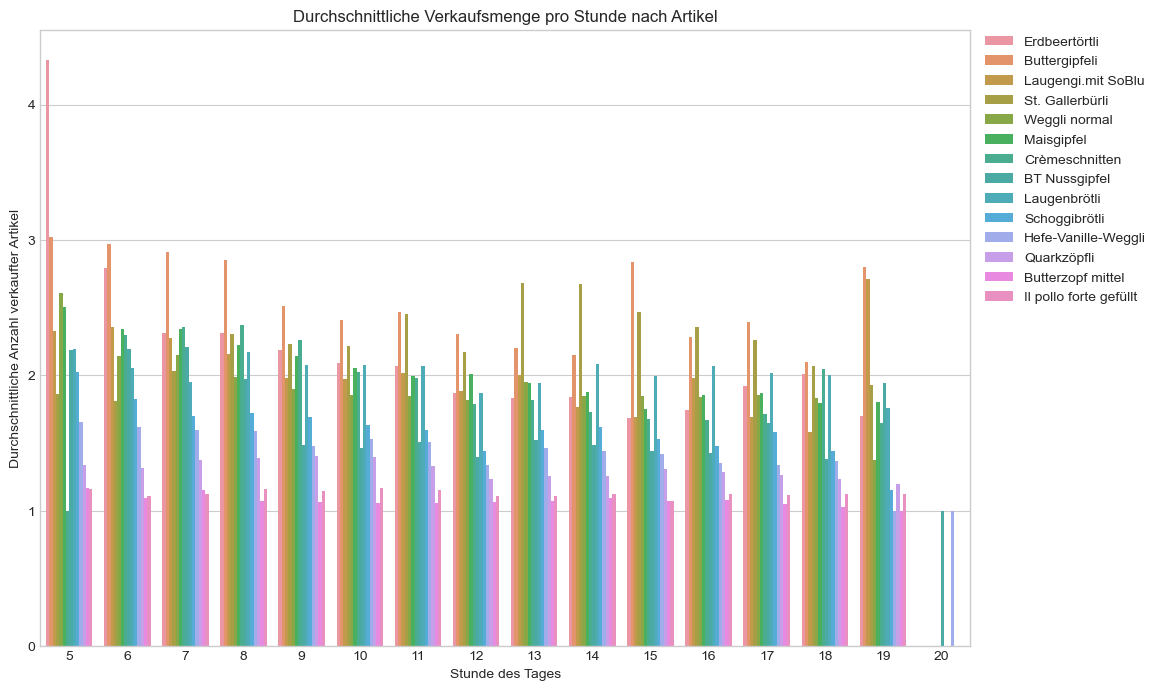

In [ ]:
# Convert the "Uhrzeit" column to a datetime format
data['Uhrzeit'] = pd.to_datetime(data['Uhrzeit'])

# Group the data by Artikel and hour of the day, and calculate the average Menge value
grouped_data = data.groupby(['Artikel', data['Uhrzeit'].dt.hour])['Menge'].mean()

# Convert the grouped data to a DataFrame
data_grouped = grouped_data.reset_index(name='avg_items_sold')

# Sort the data by the average Menge value in descending order
data_grouped_sorted = data_grouped.sort_values(by='avg_items_sold', ascending=False)

# Create the bar plot
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x='Uhrzeit', y='avg_items_sold', hue='Artikel', data=data_grouped_sorted)
ax.set(title='Durchschnittliche Verkaufsmenge pro Stunde nach Artikel', xlabel='Stunde des Tages', ylabel='Durchschnittliche Anzahl verkaufter Artikel')

ax.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.show()


# † Code Graveyard † #

In [ ]:
# Tag + Uhrzeit mit maximalem Umsatz
max_umsatz = data[data["Umsatz"] == data["Umsatz"].max()]
max_umsatz_Tag = max_umsatz["Wochentag"].values[0]
max_umsatz_stunde = max_umsatz["Uhrzeit"].values[0]
print("Der höchste Umsatz wurde am {} um {} Uhr erzielt.".format(max_umsatz_Tag, max_umsatz_stunde))



Der höchste Umsatz wurde am Sunday um 2023-03-27T15:51:41.000000000 Uhr erzielt.
